# 決定木とランダムフォレスト分析

説明変数（cpNum, cpNum_range, cpNum_dir, tree）と目的変数の関係を決定木とランダムフォレストで分析します。

## 分析タスク

1. **バグ発見の有無（二値分類）**: 各実行ごとにパラメータからバグ発見確率を予測（ロジスティック回帰分析と同じデータ構造）
2. **5回実行して1回でもバグ発見（二値分類）**: パラメータから5回中1回でもバグ発見がある確率を予測
3. **5回実行して5回全てバグ発見（二値分類）**: パラメータから5回全てバグ発見になる確率を予測


In [103]:

# 必要なライブラリのインポート
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import sem

# 日本語フォント設定
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# 可能であれば日本語フォントを設定
try:
    if os.name == 'posix':  # Mac/Linux
        japanese_fonts = ['Hiragino Sans', 'Hiragino Kaku Gothic Pro', 'Yu Gothic', 'Meiryo']
        for font in japanese_fonts:
            try:
                plt.rcParams['font.family'] = font
                break
            except:
                continue
except:
    pass

# 図のサイズ設定
plt.rcParams['figure.figsize'] = (12, 8)

print("ライブラリのインポートが完了しました")


ライブラリのインポートが完了しました


In [104]:
# データ収集関数
def parse_directory_name(dir_name):
    """
    ディレクトリ名をパースしてcpNum, cpNum_range, cpNum_dirを抽出
    
    Args:
        dir_name: ディレクトリ名（例: "0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1"）
    
    Returns:
        tuple: (cpNum, cpNum_range, cpNum_dir) または (None, None, None)
    """
    params = dir_name.split(',')
    if len(params) < 30:
        return None, None, None
    
    try:
        cpnum = None
        cpnum_range = None
        cpnum_dir = None
        
        # cpNum (0-9番目)
        for i in range(10):
            if int(params[i]) != 0:
                cpnum = int(params[i])
                break
        
        # cpNum_range (10-19番目)
        for i in range(10, 20):
            if int(params[i]) != 0:
                cpnum_range = int(params[i])
                break
        
        # cpNum_dir (20-29番目)
        for i in range(20, 30):
            if int(params[i]) != 0:
                cpnum_dir = int(params[i])
                break
        
        return cpnum, cpnum_range, cpnum_dir
    except (ValueError, IndexError):
        return None, None, None

def collect_data_for_bug_detection(logs_root='Logs'):
    """
    バグ発見の有無（二値分類）用のデータを収集
    各行（各実行）ごとに1つのデータポイントを作成し、バグ発見の有無を記録
    ロジスティック回帰分析と同じデータ構造
    
    Returns:
        pd.DataFrame: 収集したデータ
    """
    data_records = []
    logs_path = Path(logs_root)
    
    # tree=0, tree=500, tree=1000のディレクトリを処理
    for tree_dir in logs_path.glob('tree=*'):
        tree_value = int(tree_dir.name.split('=')[1])
        
        # 各パラメータディレクトリを処理
        for param_dir in tree_dir.iterdir():
            if not param_dir.is_dir():
                continue
            
            # ディレクトリ名をパース
            cpnum, cpnum_range, cpnum_dir = parse_directory_name(param_dir.name)
            if cpnum is None or cpnum_range is None or cpnum_dir is None:
                continue
            
            # ファイルパス
            detected_bugs_path = param_dir / 'detected_bugs.csv'
            
            if not os.path.exists(detected_bugs_path):
                continue
            
            # detected_bugs.csvの各行を読み込む（各実行ごとにデータポイントを作成）
            with open(detected_bugs_path, 'r') as bug_f:
                bug_reader = csv.reader(bug_f)
                for bug_row in bug_reader:
                    # バグ発見の有無を判定
                    bug_detected = 0  # バグ発見の有無（0: なし, 1: あり）
                    
                    if bug_row == ['timeout']:
                        # タイムアウトの場合はバグ発見なしとして扱う
                        bug_detected = 0
                    elif bug_row == ['null']:
                        # 正常終了の場合はバグ発見なし
                        bug_detected = 0
                    else:
                        # バグ発見
                        bug_detected = 1
                    
                    # データポイントを作成
                    data_records.append({
                        'tree': tree_value,
                        'cpNum': cpnum,
                        'cpNum_range': cpnum_range,
                        'cpNum_dir': cpnum_dir,
                        'bug_detected': bug_detected  # バグ発見の有無（二値）
                    })
    
    df = pd.DataFrame(data_records)
    print(f"データ収集完了: {len(df)}件のレコード")
    print(f"\nデータの基本統計:")
    print(df.describe())
    print(f"\nバグ発見の有無の分布:")
    print(df['bug_detected'].value_counts())
    return df

def collect_data_for_tree_analysis(logs_root='Logs'):
    """
    決定木・ランダムフォレスト用のデータを収集
    パラメータごとに5回実行の結果を集計
    
    Returns:
        pd.DataFrame: 収集したデータ
    """
    data_records = []
    logs_path = Path(logs_root)
    
    # tree=0, tree=500, tree=1000のディレクトリを処理
    for tree_dir in logs_path.glob('tree=*'):
        tree_value = int(tree_dir.name.split('=')[1])
        
        # 各パラメータディレクトリを処理
        for param_dir in tree_dir.iterdir():
            if not param_dir.is_dir():
                continue
            
            # ディレクトリ名をパース
            cpnum, cpnum_range, cpnum_dir = parse_directory_name(param_dir.name)
            if cpnum is None or cpnum_range is None or cpnum_dir is None:
                continue
            
            # ファイルパス
            detected_bugs_path = param_dir / 'detected_bugs.csv'
            exe_time_path = param_dir / 'exe_time.csv'
            
            if not os.path.exists(detected_bugs_path) or not os.path.exists(exe_time_path):
                continue
            
            # detected_bugs.csvの各行を読み込む（各実行ごと）
            bug_results = []
            with open(detected_bugs_path, 'r') as bug_f:
                bug_reader = csv.reader(bug_f)
                for bug_row in bug_reader:
                    if bug_row == ['timeout']:
                        bug_results.append('timeout')
                    elif bug_row == ['null']:
                        bug_results.append('normal')
                    else:
                        bug_results.append('bug')
            
            # 5回実行の結果を集計
            if len(bug_results) >= 5:
                # 最初の5回のみを使用
                first_5_results = bug_results[:5]
                
                # バグ発見の有無（1回でもバグ発見があれば1）
                bug_detected_any = 1 if 'bug' in first_5_results else 0
                
                # 5回全てバグ発見（5回全てbugなら1）
                bug_detected_all = 1 if all(r == 'bug' for r in first_5_results) else 0
                
                # バグ発見回数
                bug_count = sum(1 for r in first_5_results if r == 'bug')
                
                # データポイントを作成
                data_records.append({
                    'tree': tree_value,
                    'cpNum': cpnum,
                    'cpNum_range': cpnum_range,
                    'cpNum_dir': cpnum_dir,
                    'bug_detected_any': bug_detected_any,  # 1回でもバグ発見
                    'bug_detected_all': bug_detected_all,  # 5回全てバグ発見
                    'bug_count': bug_count  # バグ発見回数（0-5）
                })
    
    df = pd.DataFrame(data_records)
    print(f"データ収集完了: {len(df)}件のレコード")
    print(f"\nデータの基本統計:")
    print(df.describe())
    print(f"\n1回でもバグ発見の分布:")
    print(df['bug_detected_any'].value_counts())
    print(f"\n5回全てバグ発見の分布:")
    print(df['bug_detected_all'].value_counts())
    print(f"\nバグ発見回数の分布:")
    print(df['bug_count'].value_counts().sort_index())
    return df

# データ収集
df = collect_data_for_tree_analysis()


データ収集完了: 2160件のレコード

データの基本統計:
              tree        cpNum  cpNum_range    cpNum_dir  bug_detected_any  \
count  2160.000000  2160.000000  2160.000000  2160.000000       2160.000000   
mean    500.000000   225.000000    50.000000     1.150000          0.844444   
std     408.342825   234.059885    40.017597     0.572409          0.362517   
min       0.000000     1.000000     1.000000     1.000000          0.000000   
25%       0.000000    50.000000     1.000000     1.000000          1.000000   
50%     500.000000   149.500000    50.000000     1.000000          1.000000   
75%    1000.000000   300.000000    99.000000     1.000000          1.000000   
max    1000.000000   700.000000    99.000000     4.000000          1.000000   

       bug_detected_all    bug_count  
count       2160.000000  2160.000000  
mean           0.353241     2.881019  
std            0.478087     1.948910  
min            0.000000     0.000000  
25%            0.000000     1.000000  
50%            0.000000

In [105]:
# モデル評価関数
def evaluate_model(
    y_true, 
    y_pred, 
    y_pred_proba=None, 
    model_name="",
    X_train=None,
    y_train=None,
    X_test=None,
    y_test=None,
    model=None
):
    """
    モデルの評価指標を計算・表示
    
    Args:
        y_true: 正解ラベル（テストデータ）
        y_pred: 予測ラベル（テストデータ）
        y_pred_proba: 予測確率（ROC曲線用、オプション、テストデータ）
        model_name: モデル名
        X_train, y_train: 訓練データ特徴量, ラベル（訓練正解率計算用, オプション）
        X_test, y_test: テストデータ特徴量, ラベル（テスト正解率の真値, オプション）
        model: 学習済みモデル（訓練・テストの正解率計算用, オプション）
    """
    print(f"\n{'='*70}")
    print(f"【{model_name}】評価結果")
    print(f"{'='*70}")
    
    # 混同行列
    cm = confusion_matrix(y_true, y_pred)
    print("\n【混同行列】")
    print(cm)
    
    # 評価指標
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    print(f"\n【評価指標】")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    
    # ベースラインモデルの予測を作成
    y_pred_always_bug = np.ones(len(y_true))
    
    # ベースラインモデルの評価
    baseline_accuracy = accuracy_score(y_true, y_pred_always_bug)
    baseline_precision = precision_score(y_true, y_pred_always_bug, zero_division=0)
    baseline_recall = recall_score(y_true, y_pred_always_bug, zero_division=0)
    baseline_f1 = f1_score(y_true, y_pred_always_bug, zero_division=0)
    
    print(f"\n【ベースラインモデル】")
    print(f"Accuracy:  {baseline_accuracy:.4f}")
    print(f"Precision: {baseline_precision:.4f}")
    print(f"Recall:    {baseline_recall:.4f}")
    print(f"F1-Score:  {baseline_f1:.4f}")
    print()
    
    # 訓練データとテストデータの正解率出力
    if (model is not None) and (X_train is not None) and (y_train is not None) and (X_test is not None) and (y_test is not None):
        # モデルを使って予測を行う
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        
        # 実際の正解率（Accuracy）を計算する
        train_acc = accuracy_score(y_train, train_pred)
        test_acc = accuracy_score(y_test, test_pred)
        
        print("訓練データとテストデータの正解率比較")
        print(f"訓練データ正解率: {train_acc:.4f}")
        print(f"テストデータ正解率: {test_acc:.4f}")
    else:
        print("（訓練データ・テストデータの正解率を表示するには model, X_train, y_train, X_test, y_test をすべて渡してください）")
    
    # ROC曲線とAUC（予測確率が利用可能な場合）
    if y_pred_proba is not None:
        try:
            auc_score = roc_auc_score(y_true, y_pred_proba)
            print(f"AUC:       {auc_score:.4f}")
            
            # ROC曲線を描画
            fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.4f})')
            plt.plot([0, 1], [0, 1], 'k--', label='Random')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve - {model_name}')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()
        except Exception as e:
            print(f"AUC計算エラー: {e}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm
    }


In [106]:

# k分割交差検証関数
def perform_cross_validation(
    model,
    X,
    y,
    model_name="",
    n_splits=10,
    random_state=42
):
    """
    k分割交差検証を実行し、結果を表示・可視化
    
    Args:
        model: 学習するモデル
        X: 特徴量データ
        y: 目的変数データ
        model_name: モデル名（表示用）
        n_splits: 分割数（デフォルト: 10）
        random_state: 乱数シード（デフォルト: 42）
    
    Returns:
        dict: 評価結果の辞書
    """
    print(f"\n{'='*70}")
    print(f"【{model_name}】{n_splits}分割交差検証結果")
    print(f"{'='*70}")
    
    # StratifiedKFoldを使用（クラス不均衡に対応）
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    # 複数の評価指標を取得
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1'
    }
    
    # 交差検証を実行
    cv_results = cross_validate(
        model, X, y,
        cv=cv,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1
    )
    
    print(cv_results)
    print("Mean score: {} (+/-{})".format(np.mean(cv_results['test_accuracy']), sem(cv_results['test_accuracy'])))
    
    # 結果を整理
    results = {}
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    
    for metric in metrics:
        test_key = f'test_{metric}'
        train_key = f'train_{metric}'
        
        test_scores = cv_results[test_key]
        train_scores = cv_results[train_key] if train_key in cv_results else None
        
        results[metric] = {
            'test_mean': np.mean(test_scores),
            'test_std': np.std(test_scores),
            'test_min': np.min(test_scores),
            'test_max': np.max(test_scores),
            'test_scores': test_scores,
            'train_mean': np.mean(train_scores) if train_scores is not None else None,
            'train_std': np.std(train_scores) if train_scores is not None else None,
            'train_scores': train_scores
        }
    
    # 結果を表示
    print("\n【テストデータの評価指標（各foldの平均±標準偏差）】")
    result_df = pd.DataFrame({
        'Mean': [results[m]['test_mean'] for m in metrics],
        'Std': [results[m]['test_std'] for m in metrics],
        'Min': [results[m]['test_min'] for m in metrics],
        'Max': [results[m]['test_max'] for m in metrics]
    }, index=[m.capitalize() for m in metrics])
    print(result_df.round(4))
    
    if results['accuracy']['train_mean'] is not None:
        print("\n【訓練データの評価指標（各foldの平均±標準偏差）】")
        train_result_df = pd.DataFrame({
            'Mean': [results[m]['train_mean'] for m in metrics],
            'Std': [results[m]['train_std'] for m in metrics]
        }, index=[m.capitalize() for m in metrics])
        print(train_result_df.round(4))
    
    # 各foldのスコアを表示
    print(f"\n【各foldのテストスコア】")
    fold_scores_df = pd.DataFrame({
        'Fold': range(1, n_splits + 1),
        'Accuracy': results['accuracy']['test_scores'],
        'Precision': results['precision']['test_scores'],
        'Recall': results['recall']['test_scores'],
        'F1-Score': results['f1']['test_scores']
    })
    print(fold_scores_df.round(4))
    
    # 可視化: 箱ひげ図
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # テストスコアの箱ひげ図
    test_data = [results[m]['test_scores'] for m in metrics]
    axes[0].boxplot(test_data, labels=[m.capitalize() for m in metrics])
    axes[0].set_title(f'Test Scores Distribution ({n_splits}-Fold CV)')
    axes[0].set_ylabel('Score')
    axes[0].grid(True, alpha=0.3, axis='y')
    axes[0].set_ylim([0, 1])
    
    # 平均スコアと標準偏差のバープロット
    means = [results[m]['test_mean'] for m in metrics]
    stds = [results[m]['test_std'] for m in metrics]
    x_pos = np.arange(len(metrics))
    axes[1].bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7)
    axes[1].set_xticks(x_pos)
    axes[1].set_xticklabels([m.capitalize() for m in metrics])
    axes[1].set_title(f'Test Scores Mean ± Std ({n_splits}-Fold CV)')
    axes[1].set_ylabel('Score')
    axes[1].grid(True, alpha=0.3, axis='y')
    axes[1].set_ylim([0, 1])
    
    plt.tight_layout()
    plt.show()
    
    return results


## タスク0: バグ発見の有無（二値分類）

各実行ごとにパラメータからバグ発見の有無を予測します（ロジスティック回帰分析と同じデータ構造）。


In [107]:
# タスク0: バグ発見の有無（二値分類）の予測

# 各実行ごとのデータを収集
df_bug_detection = collect_data_for_bug_detection()

# 特徴量と目的変数の準備
X0 = df_bug_detection[['tree', 'cpNum', 'cpNum_range', 'cpNum_dir']]
y0 = df_bug_detection['bug_detected']

# 訓練データとテストデータに分割
X0_train, X0_test, y0_train, y0_test = train_test_split(
    X0, y0, test_size=0.3, random_state=42, stratify=y0
)

print(f"訓練データ数: {len(X0_train)}")
print(f"テストデータ数: {len(X0_test)}")
print(f"\n訓練データの目的変数分布:")
print(y0_train.value_counts())
print(f"\nテストデータの目的変数分布:")
print(y0_test.value_counts())


データ収集完了: 10800件のレコード

データの基本統計:
               tree         cpNum   cpNum_range     cpNum_dir  bug_detected
count  10800.000000  10800.000000  10800.000000  10800.000000  10800.000000
mean     500.000000    225.000000     50.000000      1.150000      0.576204
std      408.267192    234.016532     40.010185      0.572303      0.494182
min        0.000000      1.000000      1.000000      1.000000      0.000000
25%        0.000000     50.000000      1.000000      1.000000      0.000000
50%      500.000000    149.500000     50.000000      1.000000      1.000000
75%     1000.000000    300.000000     99.000000      1.000000      1.000000
max     1000.000000    700.000000     99.000000      4.000000      1.000000

バグ発見の有無の分布:
bug_detected
1    6223
0    4577
Name: count, dtype: int64
訓練データ数: 7560
テストデータ数: 3240

訓練データの目的変数分布:
bug_detected
1    4356
0    3204
Name: count, dtype: int64

テストデータの目的変数分布:
bug_detected
1    1867
0    1373
Name: count, dtype: int64



【決定木（バグ発見の有無）】評価結果

【混同行列】
[[1157  216]
 [ 310 1557]]

【評価指標】
Accuracy:  0.8377
Precision: 0.8782
Recall:    0.8340
F1-Score:  0.8555

【ベースラインモデル】
Accuracy:  0.5762
Precision: 0.5762
Recall:    1.0000
F1-Score:  0.7312

訓練データとテストデータの正解率比較
訓練データ正解率: 0.8483
テストデータ正解率: 0.8377
AUC:       0.8605


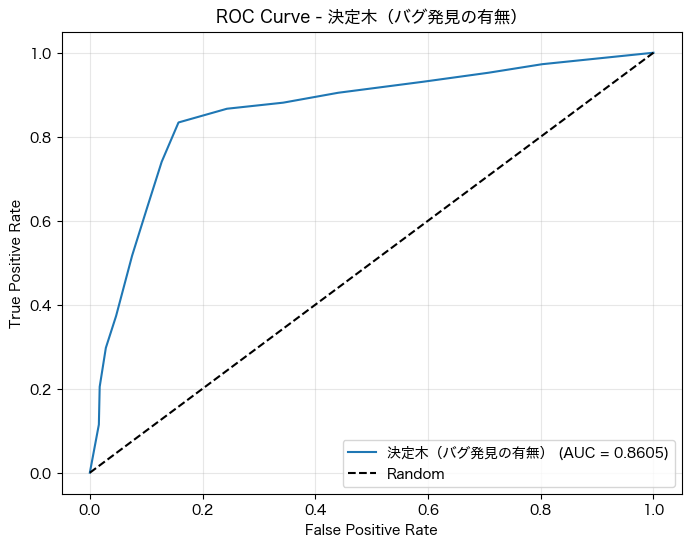

In [108]:
# 決定木モデルの訓練と評価（タスク0）
dt_model0 = DecisionTreeClassifier(
    max_depth=None,
    # min_samples_split=20,
    min_samples_leaf=0.05,
    random_state=42
)
dt_model0.fit(X0_train, y0_train)

# 予測
y0_pred_dt = dt_model0.predict(X0_test)
y0_pred_proba_dt = dt_model0.predict_proba(X0_test)[:, 1]

# 評価
dt_results0 = evaluate_model(y0_test, y0_pred_dt, y0_pred_proba_dt, "決定木（バグ発見の有無）", X0_train, y0_train, X0_test, y0_test, dt_model0)



【決定木（バグ発見の有無）】10分割交差検証結果


{'fit_time': array([0.00487399, 0.00244308, 0.00467682, 0.00248814, 0.00258207,
       0.00254512, 0.00480199, 0.00254798, 0.00373888, 0.00287485]), 'score_time': array([0.00506496, 0.00439   , 0.00726318, 0.00299382, 0.00296712,
       0.00328493, 0.00514984, 0.00722218, 0.0030961 , 0.00289512]), 'test_accuracy': array([0.83148148, 0.84166667, 0.83518519, 0.8787037 , 0.85555556,
       0.86018519, 0.81666667, 0.84907407, 0.84166667, 0.84074074]), 'train_accuracy': array([0.84660494, 0.84547325, 0.84619342, 0.84135802, 0.84393004,
       0.84341564, 0.84825103, 0.84465021, 0.84547325, 0.84557613]), 'test_precision': array([0.87436333, 0.87666667, 0.87775891, 0.90848586, 0.88196721,
       0.89315526, 0.84304207, 0.88059701, 0.87149918, 0.88527397]), 'train_precision': array([0.87968952, 0.87944444, 0.8793199 , 0.87590294, 0.87884972,
       0.87761526, 0.88331475, 0.87900686, 0.88002967, 0.87850812]), 'test_recall': array([0.82664526, 0.84430177, 0.82985554, 0.8778135 , 0.86495177,
   

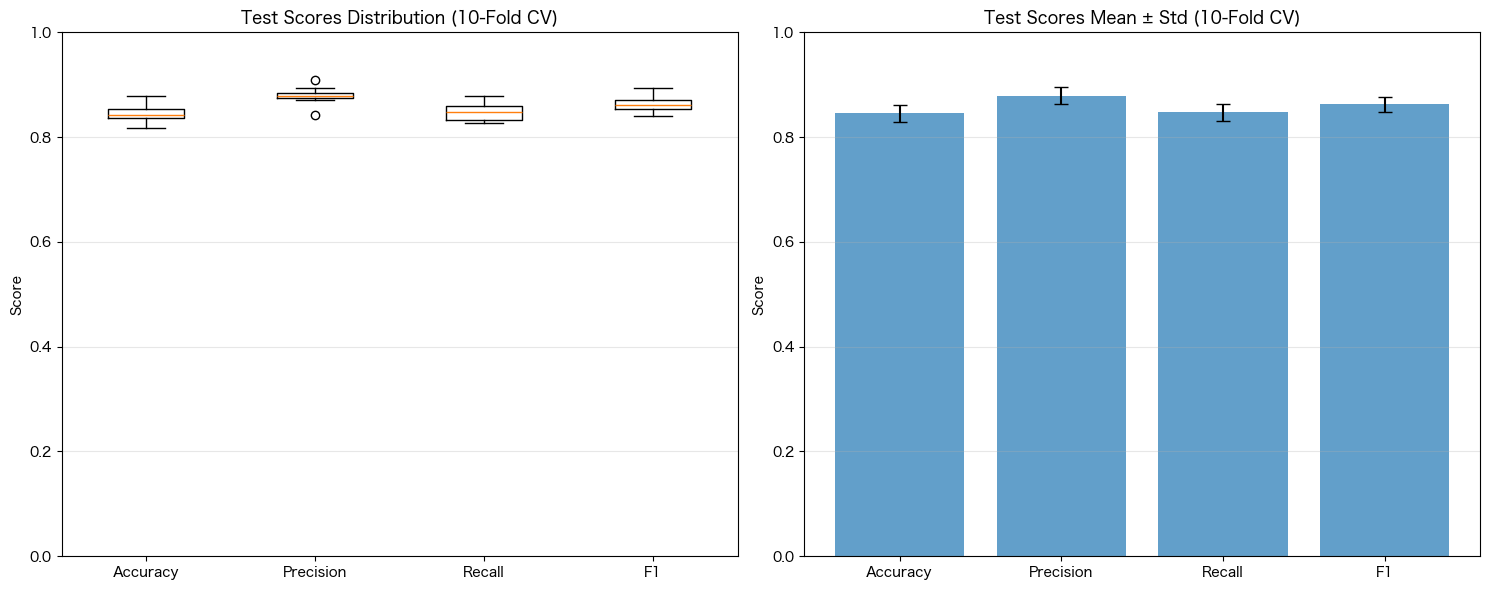

In [109]:
# タスク0: 決定木の10分割交差検証
dt_model0_cv = DecisionTreeClassifier(
    max_depth=None,
    min_samples_leaf=0.05,
    random_state=42
)

cv_results_dt0 = perform_cross_validation(
    dt_model0_cv,
    X0,
    y0,
    model_name="決定木（バグ発見の有無）",
    n_splits=10,
    random_state=42
)



【決定木】特徴量重要度（バグ発見の有無）
       feature  importance
2  cpNum_range    0.676155
1        cpNum    0.321007
0         tree    0.002838
3    cpNum_dir    0.000000


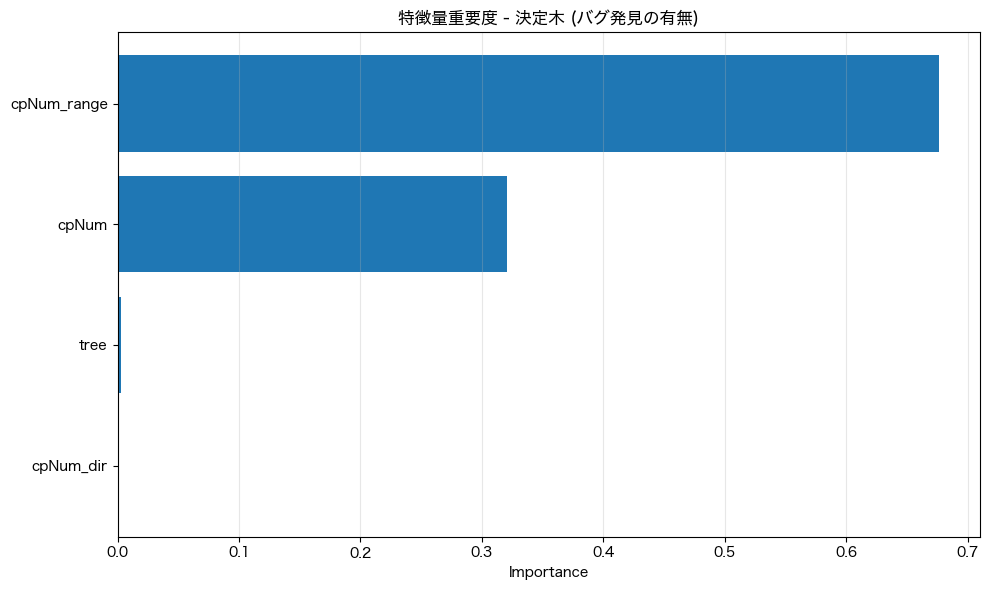

In [110]:
# 決定木の特徴量重要度（タスク0）
feature_importance_dt0 = pd.DataFrame({
    'feature': X0.columns,
    'importance': dt_model0.feature_importances_
}).sort_values('importance', ascending=False)

print("\n【決定木】特徴量重要度（バグ発見の有無）")
print(feature_importance_dt0)

# 特徴量重要度の可視化
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_dt0['feature'], feature_importance_dt0['importance'])
plt.xlabel('Importance')
plt.title('特徴量重要度 - 決定木 (バグ発見の有無)')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


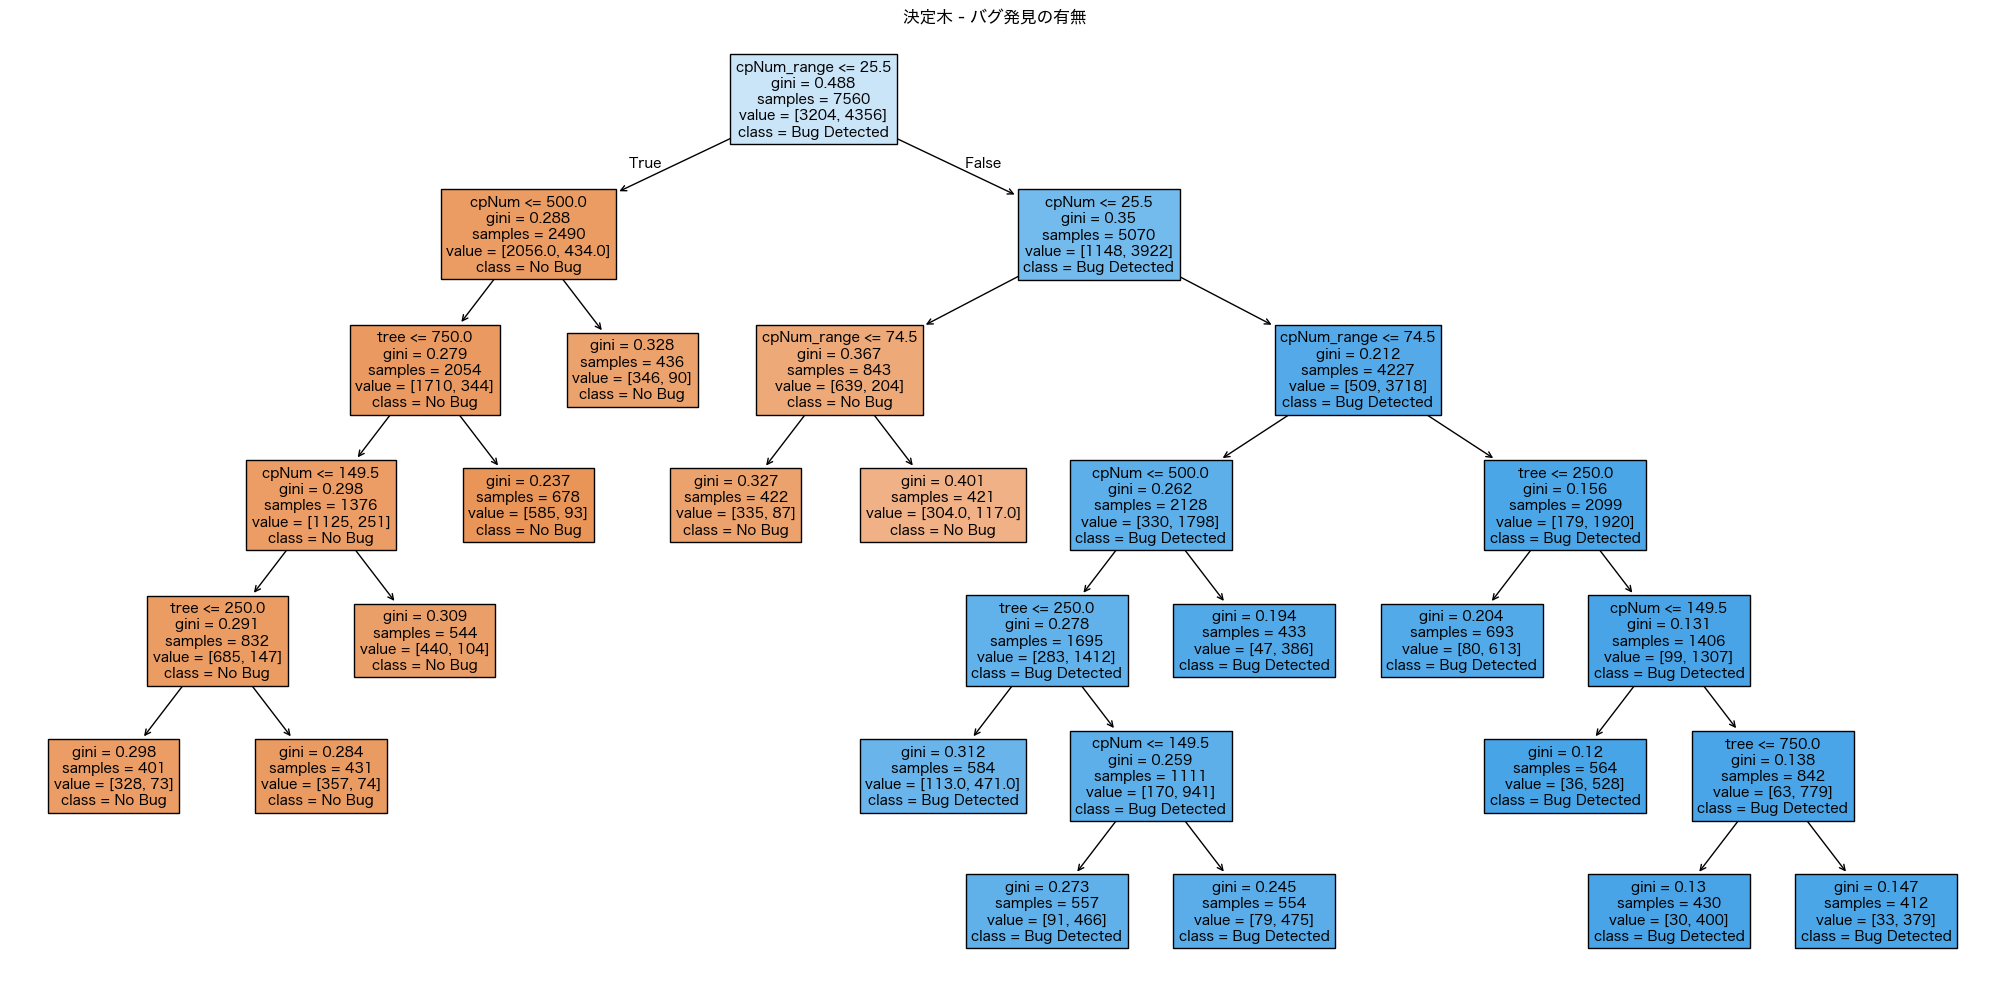

In [111]:
# 決定木の可視化（タスク0 - 深さ3まで表示）
plt.figure(figsize=(20, 10))
plot_tree(
    dt_model0,
    feature_names=X0.columns,
    class_names=['No Bug', 'Bug Detected'],
    max_depth=None,
    filled=True,
    fontsize=10
)
plt.title('決定木 - バグ発見の有無')
plt.tight_layout()
plt.show()



【ランダムフォレスト（バグ発見の有無）】評価結果

【混同行列】
[[1157  216]
 [ 310 1557]]

【評価指標】
Accuracy:  0.8377
Precision: 0.8782
Recall:    0.8340
F1-Score:  0.8555

【ベースラインモデル】
Accuracy:  0.5762
Precision: 0.5762
Recall:    1.0000
F1-Score:  0.7312

訓練データとテストデータの正解率比較
訓練データ正解率: 0.8483
テストデータ正解率: 0.8377
AUC:       0.8602


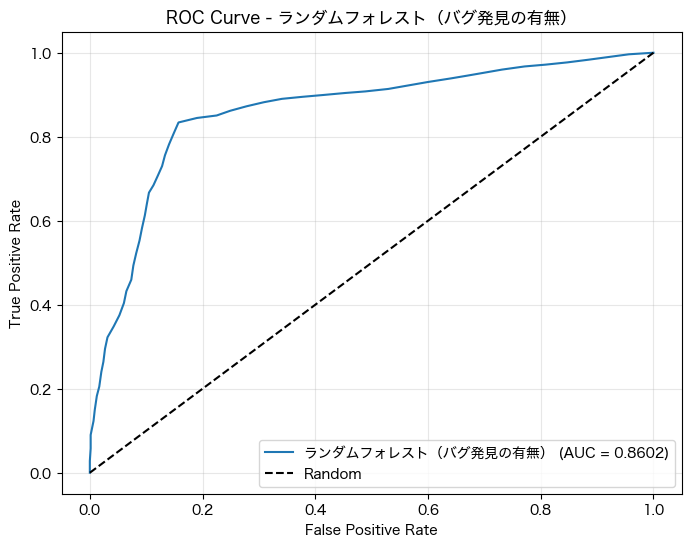

In [112]:
# ランダムフォレストモデルの訓練と評価（タスク0）
rf_model0 = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    min_samples_leaf=0.05,
    n_jobs=-1
)
rf_model0.fit(X0_train, y0_train)

# 予測
y0_pred_rf = rf_model0.predict(X0_test)
y0_pred_proba_rf = rf_model0.predict_proba(X0_test)[:, 1]

# 評価
rf_results0 = evaluate_model(y0_test, y0_pred_rf, y0_pred_proba_rf, "ランダムフォレスト（バグ発見の有無）", X0_train, y0_train, X0_test, y0_test, rf_model0)



【ランダムフォレスト（バグ発見の有無）】10分割交差検証結果
{'fit_time': array([0.20201874, 0.19867229, 0.20406294, 0.19586086, 0.20146322,
       0.19679117, 0.22314811, 0.23618174, 0.10271168, 0.10043192]), 'score_time': array([0.01684308, 0.01714683, 0.020257  , 0.01575613, 0.02581692,
       0.02856183, 0.03373098, 0.02955103, 0.01450419, 0.01696205]), 'test_accuracy': array([0.83148148, 0.84166667, 0.83518519, 0.8787037 , 0.85555556,
       0.86018519, 0.81666667, 0.84907407, 0.84166667, 0.84074074]), 'train_accuracy': array([0.84660494, 0.84547325, 0.84619342, 0.84135802, 0.84393004,
       0.84341564, 0.84825103, 0.84465021, 0.84547325, 0.84557613]), 'test_precision': array([0.87436333, 0.87666667, 0.87775891, 0.90848586, 0.88196721,
       0.89315526, 0.84304207, 0.88059701, 0.87149918, 0.88527397]), 'train_precision': array([0.87968952, 0.87944444, 0.8793199 , 0.87590294, 0.87884972,
       0.87761526, 0.88331475, 0.87900686, 0.88002967, 0.87850812]), 'test_recall': array([0.82664526, 0.84430177, 0.82985

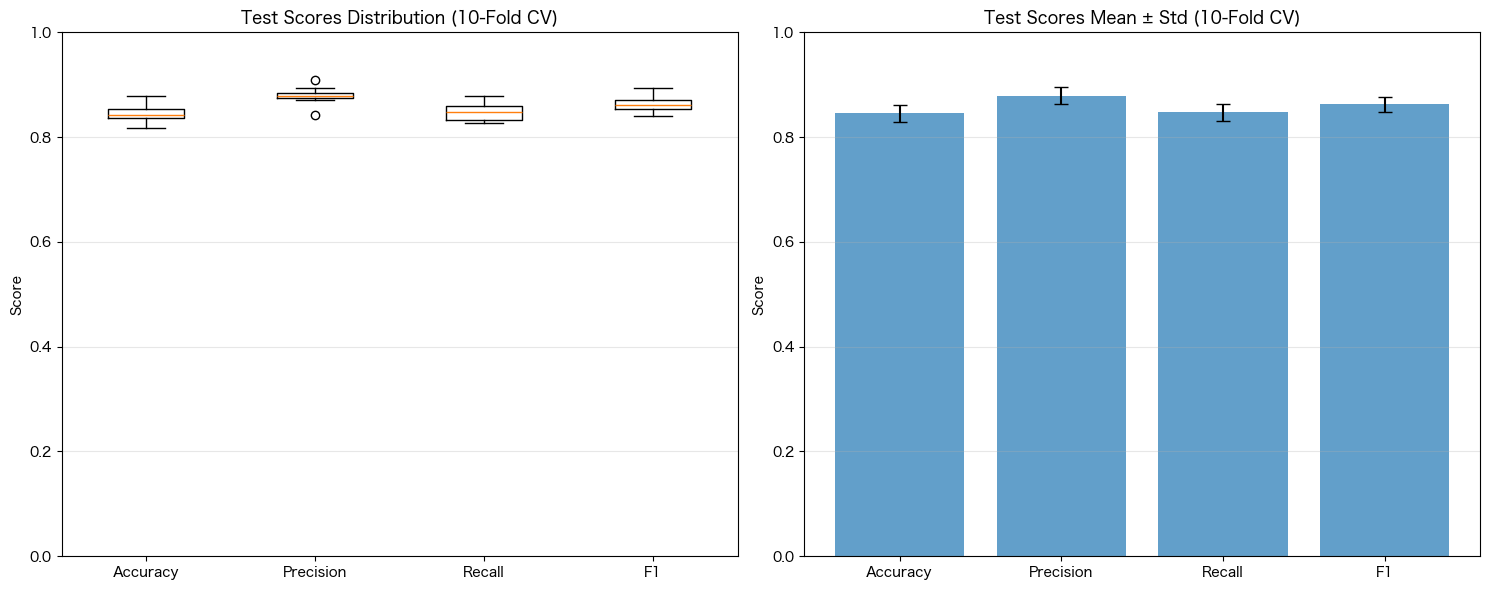

In [113]:
# タスク0: ランダムフォレストの10分割交差検証
rf_model0_cv = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    min_samples_leaf=0.05,
    n_jobs=-1
)

cv_results_rf0 = perform_cross_validation(
    rf_model0_cv,
    X0,
    y0,
    model_name="ランダムフォレスト（バグ発見の有無）",
    n_splits=10,
    random_state=42
)



【ランダムフォレスト】特徴量重要度（バグ発見の有無）
       feature  importance
2  cpNum_range    0.735361
1        cpNum    0.261861
0         tree    0.002778
3    cpNum_dir    0.000000


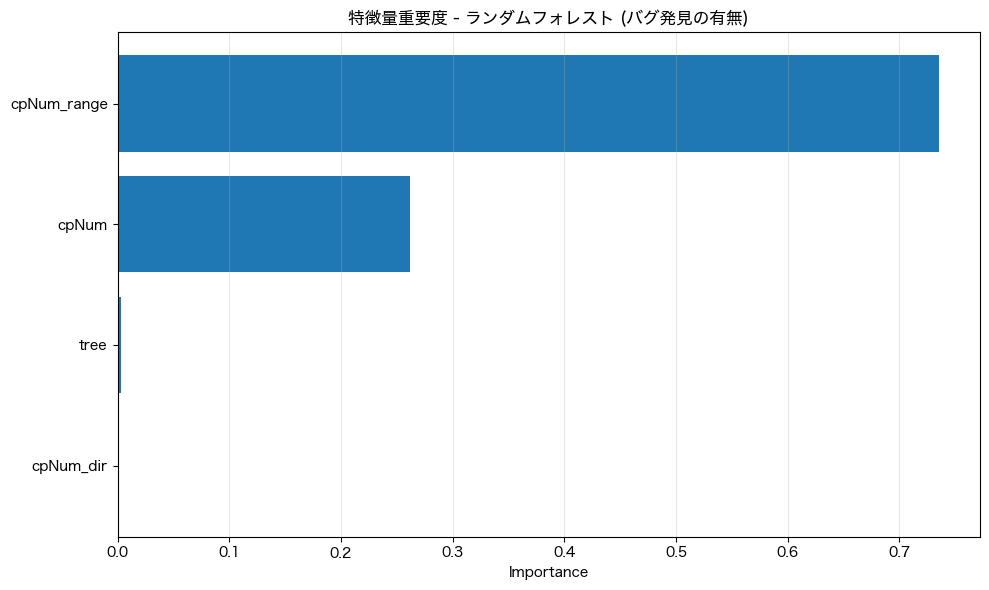

In [114]:
# ランダムフォレストの特徴量重要度（タスク0）
feature_importance_rf0 = pd.DataFrame({
    'feature': X0.columns,
    'importance': rf_model0.feature_importances_
}).sort_values('importance', ascending=False)

print("\n【ランダムフォレスト】特徴量重要度（バグ発見の有無）")
print(feature_importance_rf0)

# 特徴量重要度の可視化
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_rf0['feature'], feature_importance_rf0['importance'])
plt.xlabel('Importance')
plt.title('特徴量重要度 - ランダムフォレスト (バグ発見の有無)')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()



【タスク0: バグ発見の有無（二値分類）】モデル比較
                決定木  ランダムフォレスト
Accuracy   0.837654   0.837654
Precision  0.878173   0.878173
Recall     0.833958   0.833958
F1-Score   0.855495   0.855495


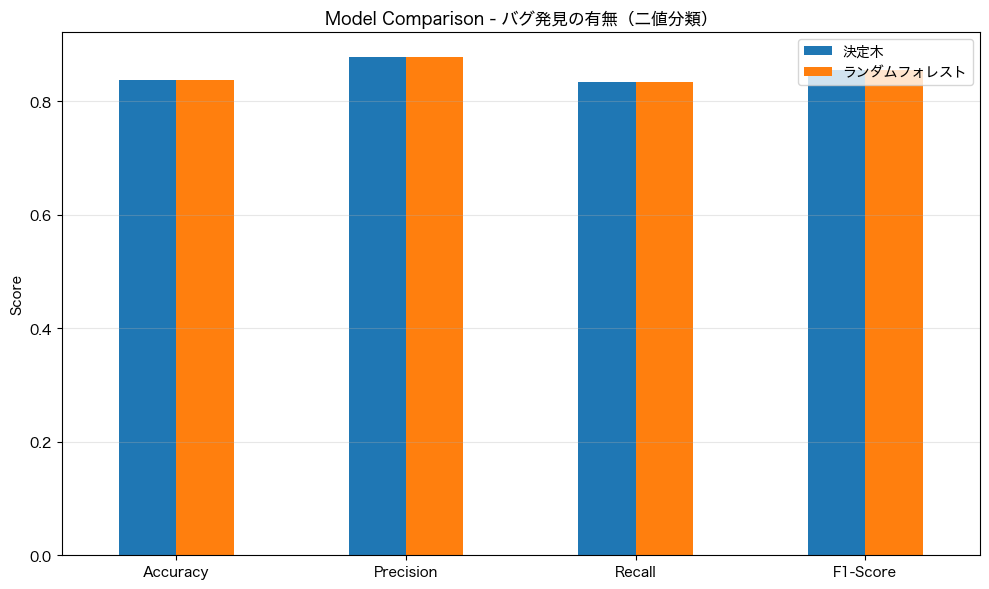

In [115]:
# タスク0の結果比較
comparison_task0 = pd.DataFrame({
    '決定木': [
        dt_results0['accuracy'],
        dt_results0['precision'],
        dt_results0['recall'],
        dt_results0['f1']
    ],
    'ランダムフォレスト': [
        rf_results0['accuracy'],
        rf_results0['precision'],
        rf_results0['recall'],
        rf_results0['f1']
    ]
}, index=['Accuracy', 'Precision', 'Recall', 'F1-Score'])

print("\n【タスク0: バグ発見の有無（二値分類）】モデル比較")
print(comparison_task0)

# 可視化
comparison_task0.plot(kind='bar', figsize=(10, 6))
plt.title('Model Comparison - バグ発見の有無（二値分類）')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()



【タスク0: バグ発見の有無（二値分類）】モデル比較
           ロジスティクス回帰       決定木  ランダムフォレスト
Accuracy      0.8134  0.837654   0.837654
Precision     0.8142  0.878173   0.878173
Recall        0.8763  0.833958   0.833958
F1-Score      0.8441  0.855495   0.855495


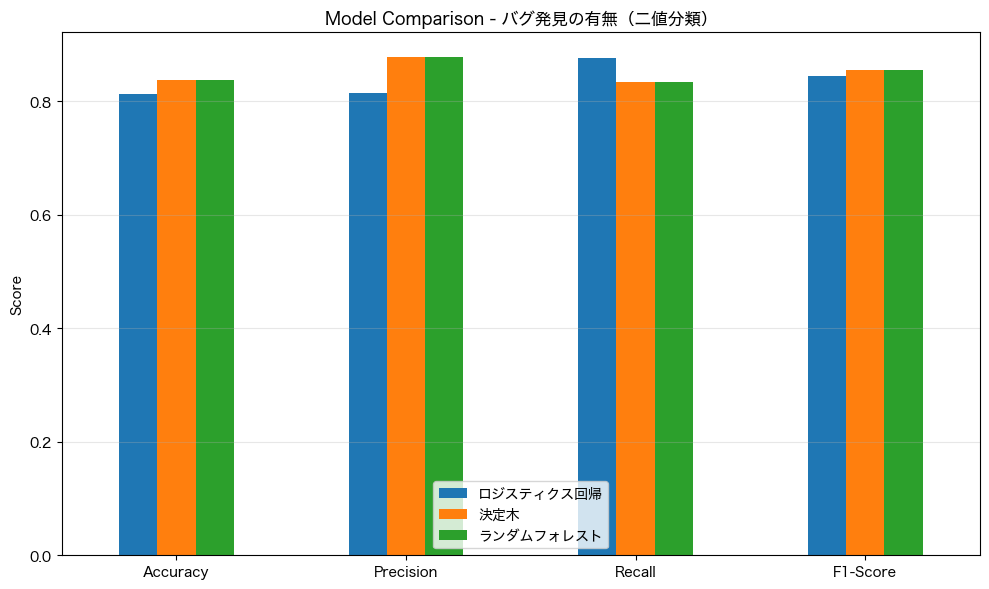

In [116]:
# ロジスティクス回帰，決定木，ランダムフォレストの比較

# タスク0の結果比較
comparison_task0 = pd.DataFrame({
    'ロジスティクス回帰': [
        0.8134,
        0.8142,
        0.8763,
        0.8441
    ],
    '決定木': [
        dt_results0['accuracy'],
        dt_results0['precision'],
        dt_results0['recall'],
        dt_results0['f1']
    ],
    'ランダムフォレスト': [
        rf_results0['accuracy'],
        rf_results0['precision'],
        rf_results0['recall'],
        rf_results0['f1']
    ]
}, index=['Accuracy', 'Precision', 'Recall', 'F1-Score'])

print("\n【タスク0: バグ発見の有無（二値分類）】モデル比較")
print(comparison_task0)

# 可視化
comparison_task0.plot(kind='bar', figsize=(10, 6))
plt.title('Model Comparison - バグ発見の有無（二値分類）')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## タスク1: 5回実行して1回でもバグ発見の予測


In [117]:
# タスク1: バグ発見の有無（1回でもバグ発見）の予測

# 特徴量と目的変数の準備
X1 = df[['tree', 'cpNum', 'cpNum_range', 'cpNum_dir']]
y1 = df['bug_detected_any']

# 訓練データとテストデータに分割
X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1, y1, test_size=0.2, random_state=42, stratify=y1
)

print(f"訓練データ数: {len(X1_train)}")
print(f"テストデータ数: {len(X1_test)}")
print(f"\n訓練データの目的変数分布:")
print(y1_train.value_counts())
print(f"\nテストデータの目的変数分布:")
print(y1_test.value_counts())


訓練データ数: 1728
テストデータ数: 432

訓練データの目的変数分布:
bug_detected_any
1    1459
0     269
Name: count, dtype: int64

テストデータの目的変数分布:
bug_detected_any
1    365
0     67
Name: count, dtype: int64



【決定木（1回でもバグ発見）】評価結果

【混同行列】
[[ 66   1]
 [115 250]]

【評価指標】
Accuracy:  0.7315
Precision: 0.9960
Recall:    0.6849
F1-Score:  0.8117

【ベースラインモデル】
Accuracy:  0.8449
Precision: 0.8449
Recall:    1.0000
F1-Score:  0.9159

訓練データとテストデータの正解率比較
訓練データ正解率: 0.6991
テストデータ正解率: 0.7315
AUC:       0.8615


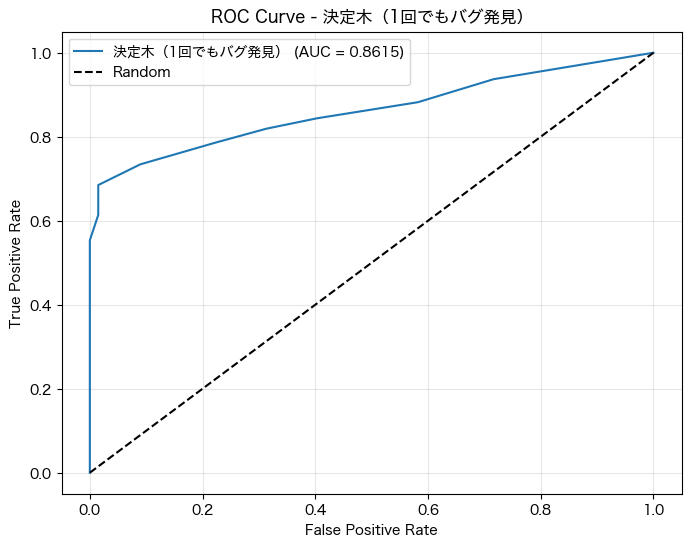

In [118]:
# 決定木モデルの訓練と評価（タスク1）
dt1_model = DecisionTreeClassifier(
    max_depth=None,
    min_samples_leaf=0.05,
    random_state=42,
    class_weight='balanced'
)
dt1_model.fit(X1_train, y1_train)

# 予測
y1_pred_dt = dt1_model.predict(X1_test)
y1_pred_proba_dt = dt1_model.predict_proba(X1_test)[:, 1]

# 評価
dt1_results = evaluate_model(y1_test, y1_pred_dt, y1_pred_proba_dt, "決定木（1回でもバグ発見）", X1_train, y1_train, X1_test, y1_test, dt1_model)



【決定木（1回でもバグ発見）】10分割交差検証結果
{'fit_time': array([0.00157905, 0.00184107, 0.004318  , 0.00193691, 0.00200915,
       0.00149202, 0.00155592, 0.00281811, 0.0021441 , 0.0015161 ]), 'score_time': array([0.00342083, 0.00588298, 0.00449991, 0.00320888, 0.0027678 ,
       0.00364995, 0.00608897, 0.00251913, 0.00245476, 0.00243807]), 'test_accuracy': array([0.71296296, 0.74074074, 0.67592593, 0.68518519, 0.69907407,
       0.6712963 , 0.68981481, 0.74074074, 0.71759259, 0.73148148]), 'train_accuracy': array([0.70473251, 0.70164609, 0.70884774, 0.70781893, 0.70627572,
       0.70936214, 0.70730453, 0.70164609, 0.70421811, 0.74279835]), 'test_precision': array([1.        , 1.        , 0.99130435, 1.        , 0.98347107,
       1.        , 0.98319328, 0.9921875 , 1.        , 0.95588235]), 'train_precision': array([0.9944393 , 0.9944082 , 0.99539171, 0.99447005, 0.99629286,
       0.99449036, 0.99629972, 0.99533582, 0.9944393 , 0.98226351]), 'test_recall': array([0.66120219, 0.69398907, 0.62295082, 

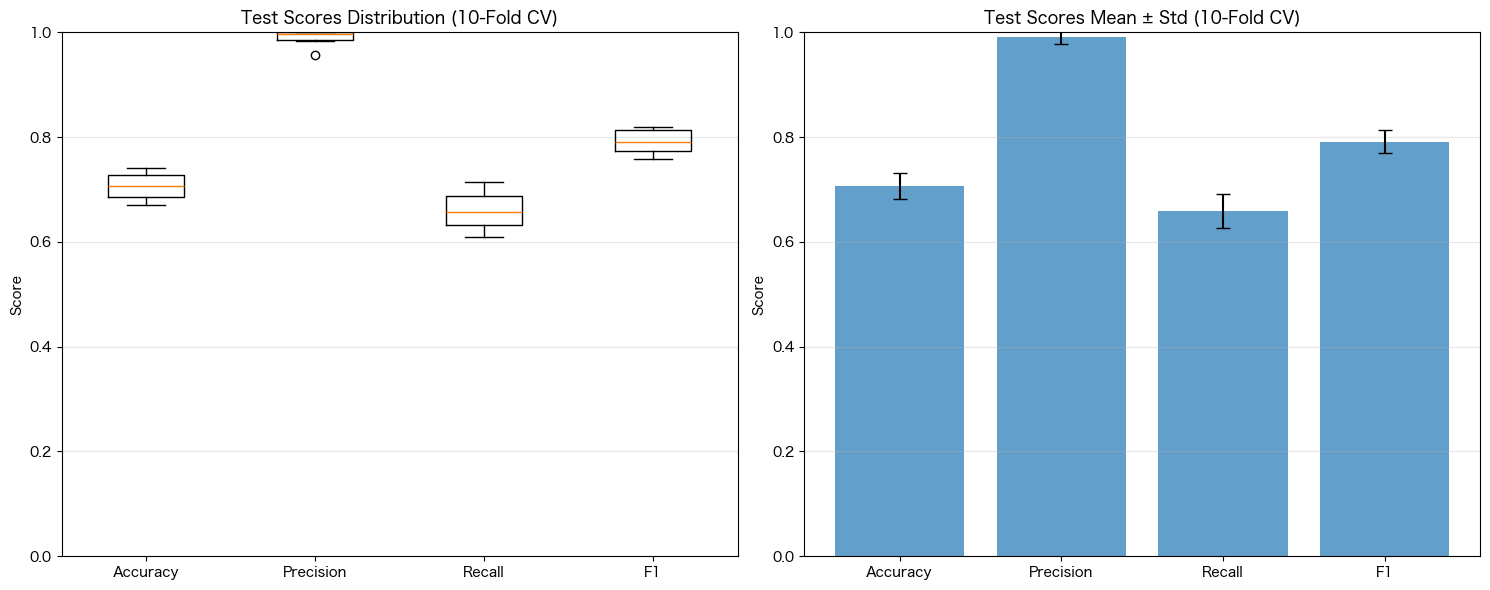

In [119]:
# タスク1: 決定木の10分割交差検証
dt1_model_cv = DecisionTreeClassifier(
    max_depth=None,
    min_samples_leaf=0.05,
    random_state=42,
    class_weight='balanced'
)

cv_results_dt1 = perform_cross_validation(
    dt1_model_cv,
    X1,
    y1,
    model_name="決定木（1回でもバグ発見）",
    n_splits=10,
    random_state=42
)



【決定木】特徴量重要度（1回でもバグ発見）
       feature  importance
2  cpNum_range    0.634608
1        cpNum    0.361078
0         tree    0.004314
3    cpNum_dir    0.000000


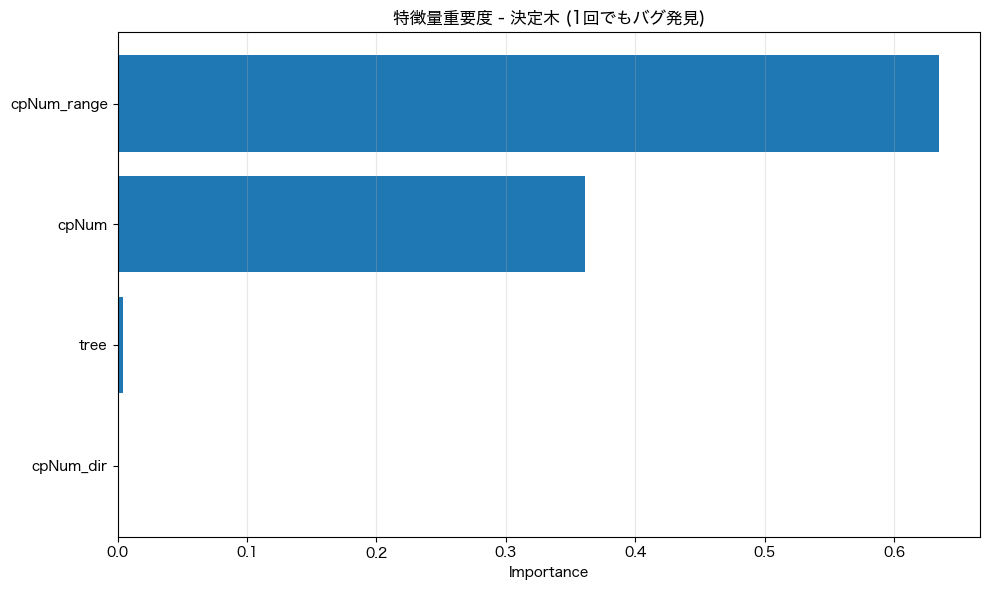

In [120]:
# 決定木の特徴量重要度（タスク1）
feature_importance_dt1 = pd.DataFrame({
    'feature': X1.columns,
    'importance': dt1_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n【決定木】特徴量重要度（1回でもバグ発見）")
print(feature_importance_dt1)

# 特徴量重要度の可視化
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_dt1['feature'], feature_importance_dt1['importance'])
plt.xlabel('Importance')
plt.title('特徴量重要度 - 決定木 (1回でもバグ発見)')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


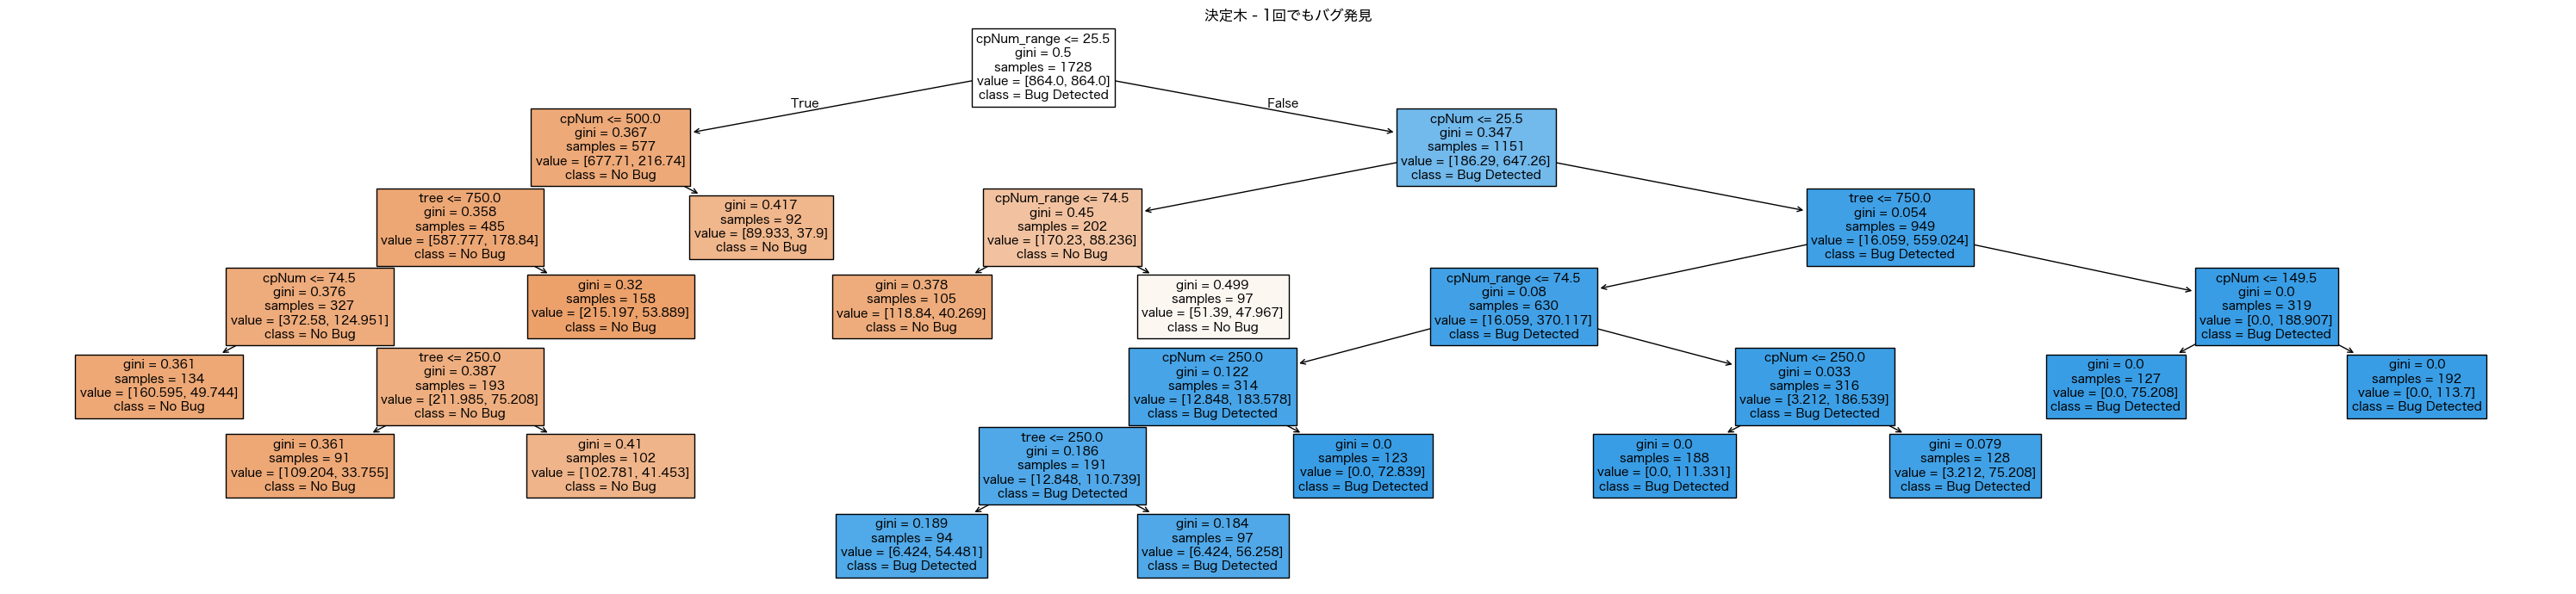

In [121]:
# 決定木の可視化（タスク0 - 深さ3まで表示）
plt.figure(figsize=(30, 7))
plot_tree(
    dt1_model,
    feature_names=X1.columns,
    class_names=['No Bug', 'Bug Detected'],
    max_depth=None,
    filled=True,
    fontsize=10
)
plt.title('決定木 - 1回でもバグ発見')
plt.tight_layout()
plt.show()


【ランダムフォレスト（1回でもバグ発見）】評価結果

【混同行列】
[[ 66   1]
 [115 250]]

【評価指標】
Accuracy:  0.7315
Precision: 0.9960
Recall:    0.6849
F1-Score:  0.8117

【ベースラインモデル】
Accuracy:  0.8449
Precision: 0.8449
Recall:    1.0000
F1-Score:  0.9159

訓練データとテストデータの正解率比較
訓練データ正解率: 0.6991
テストデータ正解率: 0.7315
AUC:       0.8695


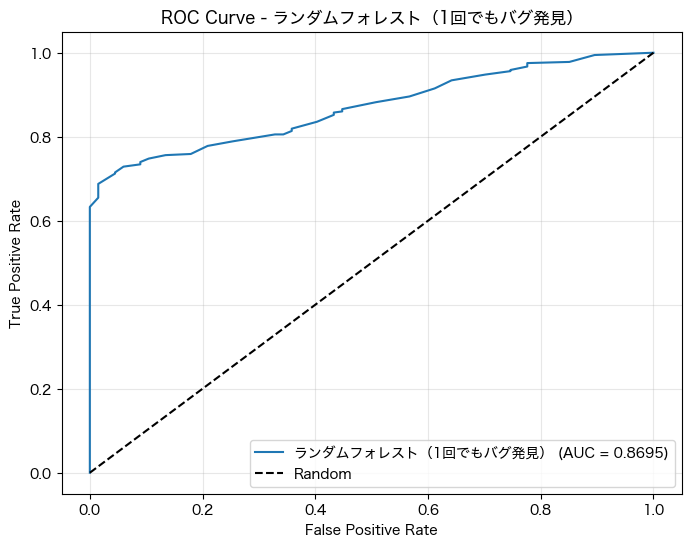

In [122]:
# ランダムフォレストモデルの訓練と評価（タスク1）
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    min_samples_leaf=0.05,
    n_jobs=-1,
    class_weight='balanced',
)
rf_model.fit(X1_train, y1_train)

# 予測
y1_pred_rf = rf_model.predict(X1_test)
y1_pred_proba_rf = rf_model.predict_proba(X1_test)[:, 1]

# 評価
rf1_results = evaluate_model(y1_test, y1_pred_rf, y1_pred_proba_rf, "ランダムフォレスト（1回でもバグ発見）", X1_train, y1_train, X1_test, y1_test, rf_model)



【ランダムフォレスト（1回でもバグ発見）】10分割交差検証結果
{'fit_time': array([0.0891211 , 0.09979701, 0.10134983, 0.09701085, 0.09950423,
       0.11187196, 0.09790087, 0.08898401, 0.06915116, 0.06376195]), 'score_time': array([0.02029991, 0.01710892, 0.01648808, 0.01866698, 0.01710105,
       0.01762104, 0.02064919, 0.01725316, 0.01601982, 0.01416183]), 'test_accuracy': array([0.71296296, 0.74074074, 0.67592593, 0.68518519, 0.69907407,
       0.6712963 , 0.68981481, 0.74074074, 0.71759259, 0.72222222]), 'train_accuracy': array([0.70473251, 0.70164609, 0.70884774, 0.70781893, 0.70627572,
       0.70936214, 0.70730453, 0.70164609, 0.70421811, 0.7037037 ]), 'test_precision': array([1.        , 1.        , 0.99130435, 1.        , 0.98347107,
       1.        , 0.98319328, 0.9921875 , 1.        , 1.        ]), 'train_precision': array([0.9944393 , 0.9944082 , 0.99539171, 0.99447005, 0.99629286,
       0.99449036, 0.99629972, 0.99533582, 0.9944393 , 0.99443414]), 'test_recall': array([0.66120219, 0.69398907, 0.6229

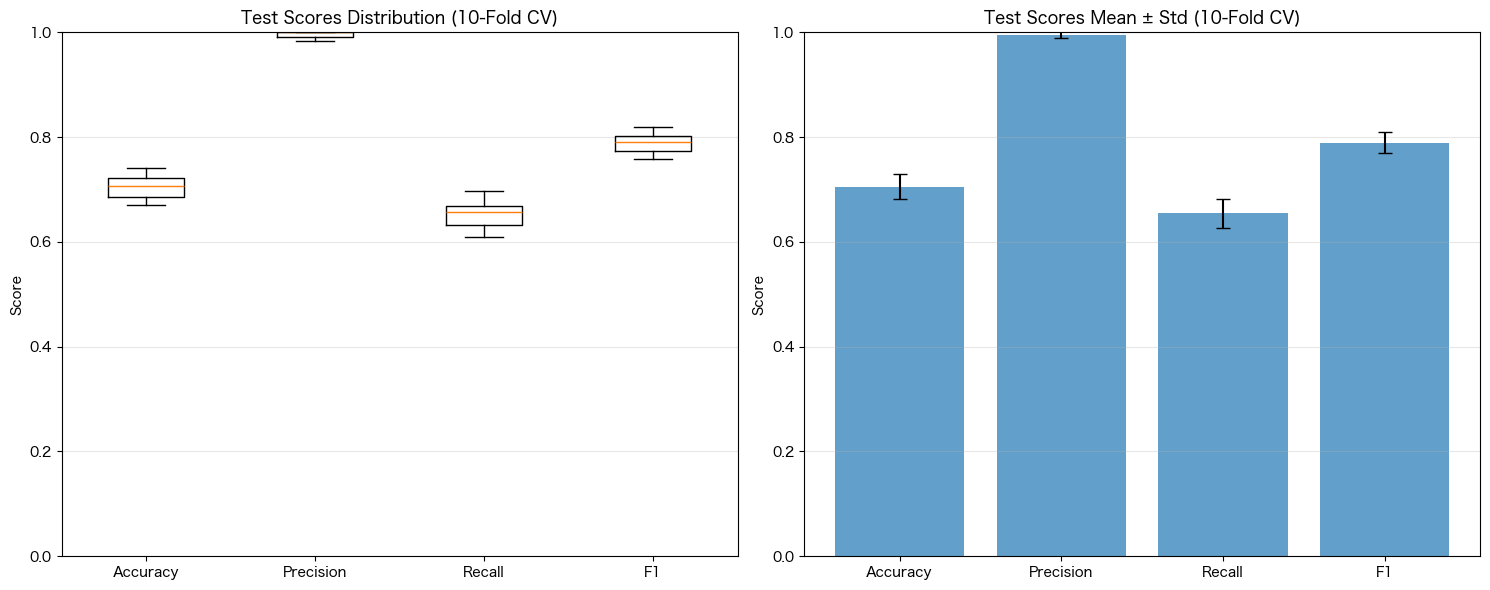

In [123]:
# タスク1: ランダムフォレストの10分割交差検証
rf_model1_cv = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    class_weight='balanced',
    random_state=42,
    min_samples_leaf=0.05,
    n_jobs=-1
)

cv_results_rf1 = perform_cross_validation(
    rf_model1_cv,
    X1,
    y1,
    model_name="ランダムフォレスト（1回でもバグ発見）",
    n_splits=10,
    random_state=42
)



【ランダムフォレスト】特徴量重要度（1回でもバグ発見）
       feature  importance
2  cpNum_range    0.737334
1        cpNum    0.248194
0         tree    0.014264
3    cpNum_dir    0.000208


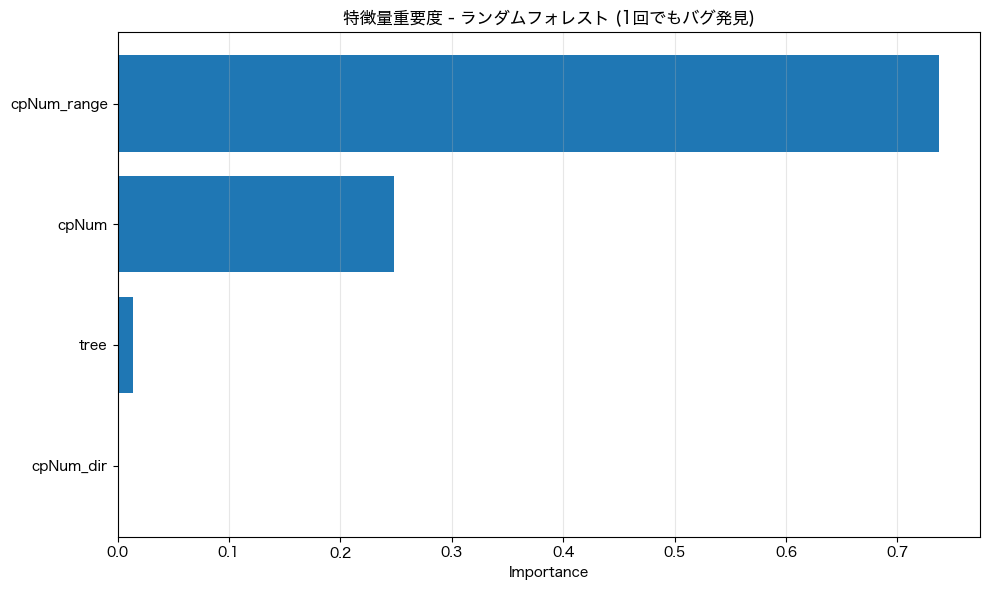

In [124]:
# ランダムフォレストの特徴量重要度（タスク1）
feature_importance_rf1 = pd.DataFrame({
    'feature': X1.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n【ランダムフォレスト】特徴量重要度（1回でもバグ発見）")
print(feature_importance_rf1)

# 特徴量重要度の可視化
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_rf1['feature'], feature_importance_rf1['importance'])
plt.xlabel('Importance')
plt.title('特徴量重要度 - ランダムフォレスト (1回でもバグ発見)')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()



【タスク1: 1回でもバグ発見】モデル比較
                決定木  ランダムフォレスト
Accuracy   0.731481   0.731481
Precision  0.996016   0.996016
Recall     0.684932   0.684932
F1-Score   0.811688   0.811688


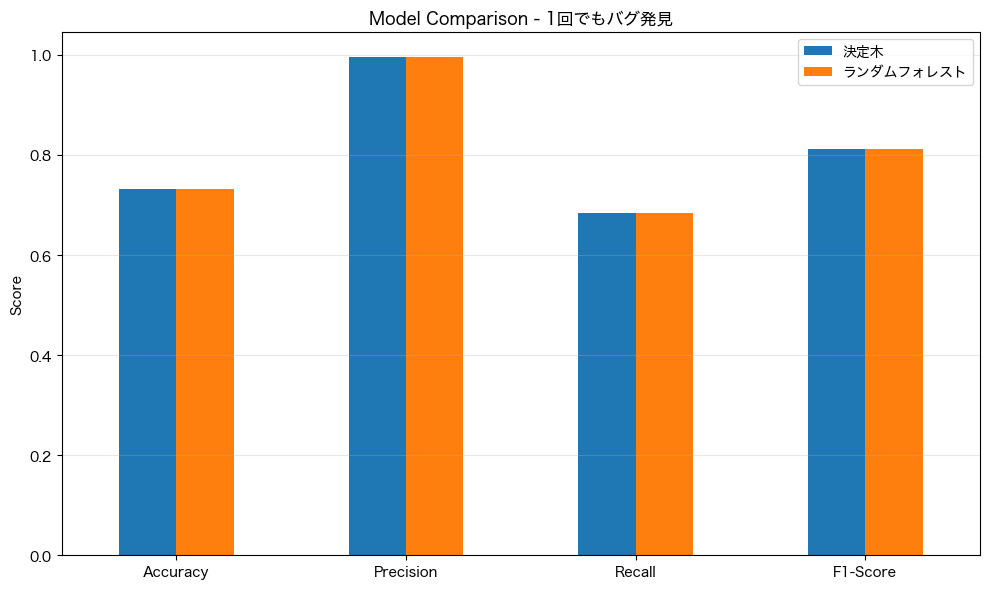

In [125]:
# タスク1の結果比較
comparison_task1 = pd.DataFrame({
    '決定木': [
        dt1_results['accuracy'],
        dt1_results['precision'],
        dt1_results['recall'],
        dt1_results['f1']
    ],
    'ランダムフォレスト': [
        rf1_results['accuracy'],
        rf1_results['precision'],
        rf1_results['recall'],
        rf1_results['f1']
    ]
}, index=['Accuracy', 'Precision', 'Recall', 'F1-Score'])

print("\n【タスク1: 1回でもバグ発見】モデル比較")
print(comparison_task1)

# 可視化
comparison_task1.plot(kind='bar', figsize=(10, 6))
plt.title('Model Comparison - 1回でもバグ発見')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()



【タスク1: 1回でもバグ発見】モデル比較
           ロジスティクス回帰       決定木  ランダムフォレスト
Accuracy      0.7900  0.731481   0.731481
Precision     0.7859  0.996016   0.996016
Recall        0.9111  0.684932   0.684932
F1-Score      0.8439  0.811688   0.811688


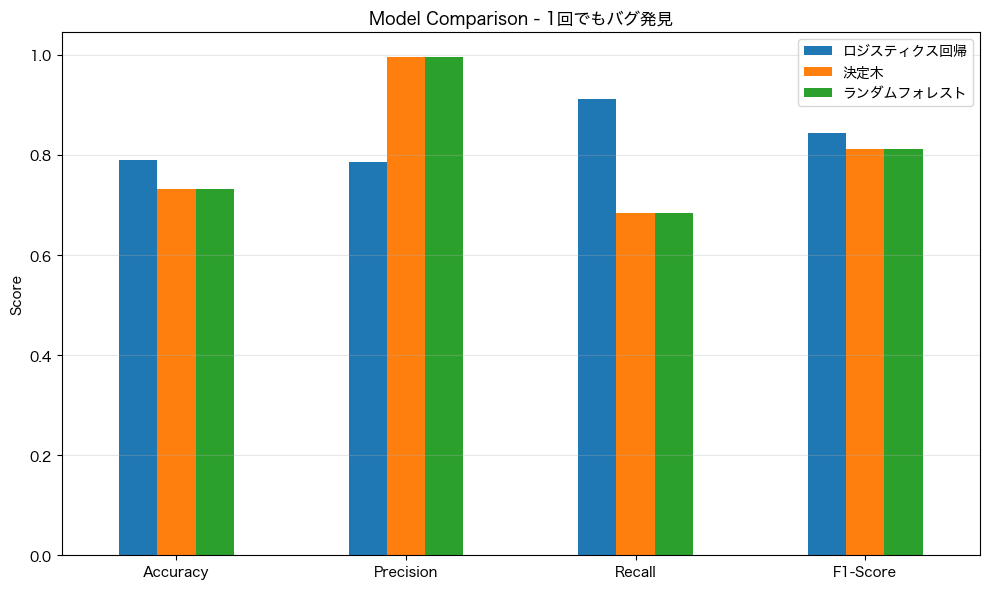

In [126]:
# ロジスティクス回帰，決定木，ランダムフォレストの比較
# タスク1の結果比較
comparison_task1 = pd.DataFrame({
    'ロジスティクス回帰': [
        0.79,
        0.7859,
        0.9111,
        0.8439
    ],
    '決定木': [
        dt1_results['accuracy'],
        dt1_results['precision'],
        dt1_results['recall'],
        dt1_results['f1']
    ],
    'ランダムフォレスト': [
        rf1_results['accuracy'],
        rf1_results['precision'],
        rf1_results['recall'],
        rf1_results['f1']
    ]
}, index=['Accuracy', 'Precision', 'Recall', 'F1-Score'])

print("\n【タスク1: 1回でもバグ発見】モデル比較")
print(comparison_task1)

# 可視化
comparison_task1.plot(kind='bar', figsize=(10, 6))
plt.title('Model Comparison - 1回でもバグ発見')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## タスク2: 5回実行して5回全てバグ発見の予測


In [127]:
# タスク2: 5回実行して5回全てバグ発見の予測

# 特徴量と目的変数の準備
X2 = df[['tree', 'cpNum', 'cpNum_range', 'cpNum_dir']]
y2 = df['bug_detected_all']

# 訓練データとテストデータに分割
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.2, random_state=42, stratify=y2
)

print(f"訓練データ数: {len(X2_train)}")
print(f"テストデータ数: {len(X2_test)}")
print(f"\n訓練データの目的変数分布:")
print(y2_train.value_counts())
print(f"\nテストデータの目的変数分布:")
print(y2_test.value_counts())


訓練データ数: 1728
テストデータ数: 432

訓練データの目的変数分布:
bug_detected_all
0    1118
1     610
Name: count, dtype: int64

テストデータの目的変数分布:
bug_detected_all
0    279
1    153
Name: count, dtype: int64



【決定木（5回全てバグ発見）】評価結果

【混同行列】
[[210  69]
 [ 47 106]]

【評価指標】
Accuracy:  0.7315
Precision: 0.6057
Recall:    0.6928
F1-Score:  0.6463

【ベースラインモデル】
Accuracy:  0.3542
Precision: 0.3542
Recall:    1.0000
F1-Score:  0.5231

訓練データとテストデータの正解率比較
訓練データ正解率: 0.8061
テストデータ正解率: 0.7315
AUC:       0.8419


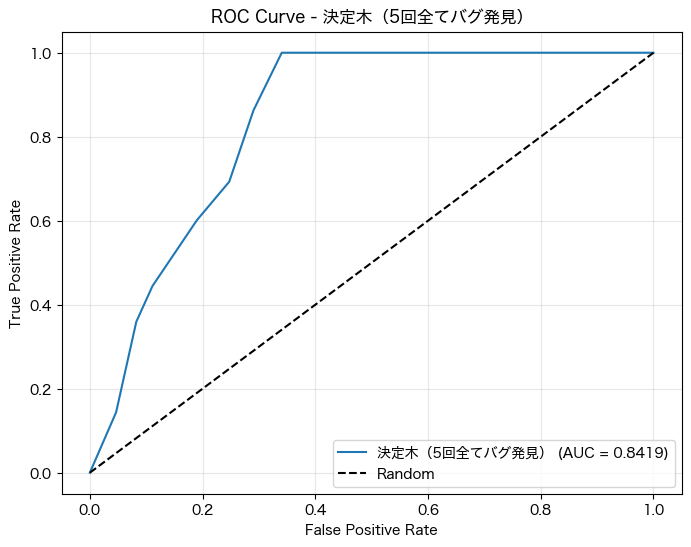

In [128]:

# 決定木モデルの訓練と評価（タスク2）
dt_model2 = DecisionTreeClassifier(
    max_depth=None,
    min_samples_leaf=0.05,
    random_state=42
)
dt_model2.fit(X2_train, y2_train)

# 予測
y2_pred_dt = dt_model2.predict(X2_test)
y2_pred_proba_dt = dt_model2.predict_proba(X2_test)[:, 1]

# 評価
dt_results2 = evaluate_model(y2_test, y2_pred_dt, y2_pred_proba_dt, "決定木（5回全てバグ発見）", X2_train, y2_train, X2_test, y2_test, dt_model2)



【決定木（5回全てバグ発見）】10分割交差検証結果
{'fit_time': array([0.00111103, 0.00145602, 0.00196314, 0.00206375, 0.00172734,
       0.00152278, 0.00158811, 0.00145102, 0.00118136, 0.00126314]), 'score_time': array([0.00245786, 0.00445604, 0.00363111, 0.00269818, 0.00502181,
       0.00404501, 0.0031898 , 0.0045011 , 0.00260472, 0.00336003]), 'test_accuracy': array([0.76851852, 0.76388889, 0.76851852, 0.81481481, 0.8287037 ,
       0.75      , 0.84259259, 0.81018519, 0.76851852, 0.78240741]), 'train_accuracy': array([0.80092593, 0.80041152, 0.79989712, 0.79475309, 0.79423868,
       0.80195473, 0.79269547, 0.7962963 , 0.80092593, 0.79938272]), 'test_precision': array([0.62385321, 0.6015625 , 0.60629921, 0.65517241, 0.70526316,
       0.58461538, 0.72340426, 0.66055046, 0.63265306, 0.62831858]), 'train_precision': array([0.65396498, 0.63899254, 0.63839702, 0.63284133, 0.65185185,
       0.6411215 , 0.65010571, 0.65628357, 0.65923567, 0.66019417]), 'test_recall': array([0.88311688, 1.        , 1.        , 

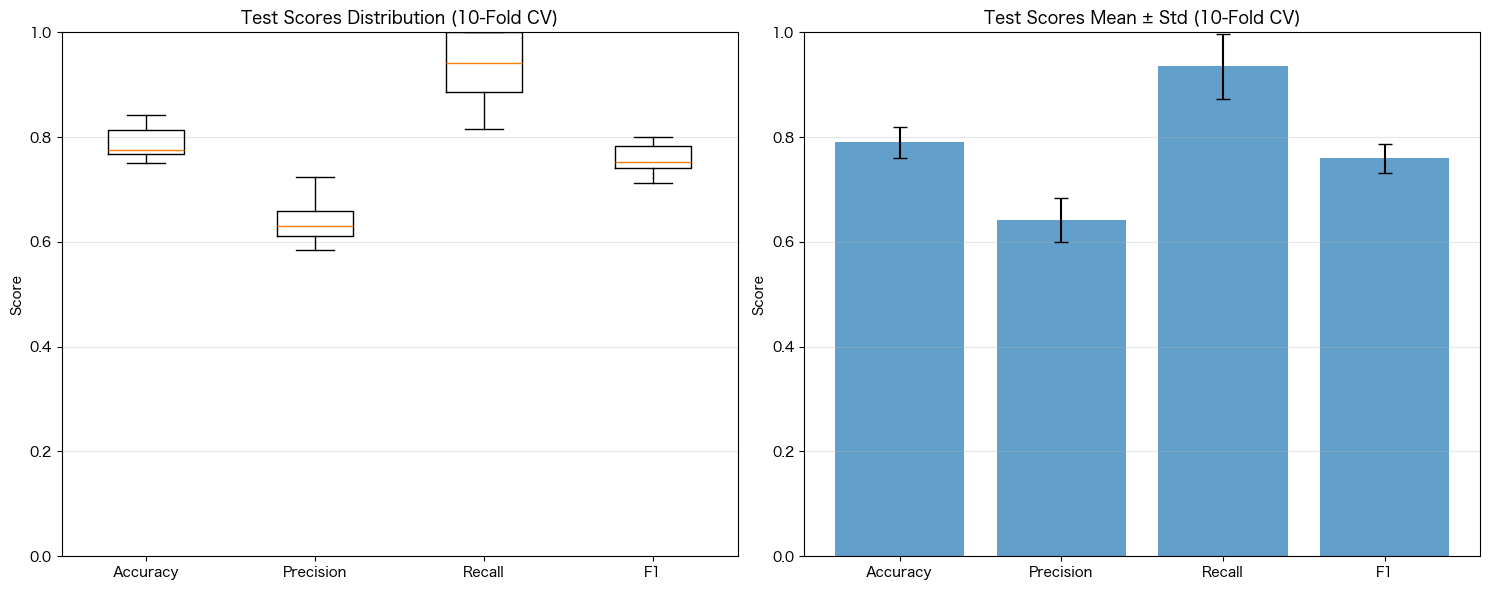

In [129]:

# タスク2: 決定木の10分割交差検証
dt_model2_cv = DecisionTreeClassifier(
    max_depth=None,
    min_samples_leaf=0.05,
    random_state=42
)

cv_results_dt2 = perform_cross_validation(
    dt_model2_cv,
    X2,
    y2,
    model_name="決定木（5回全てバグ発見）",
    n_splits=10,
    random_state=42
)

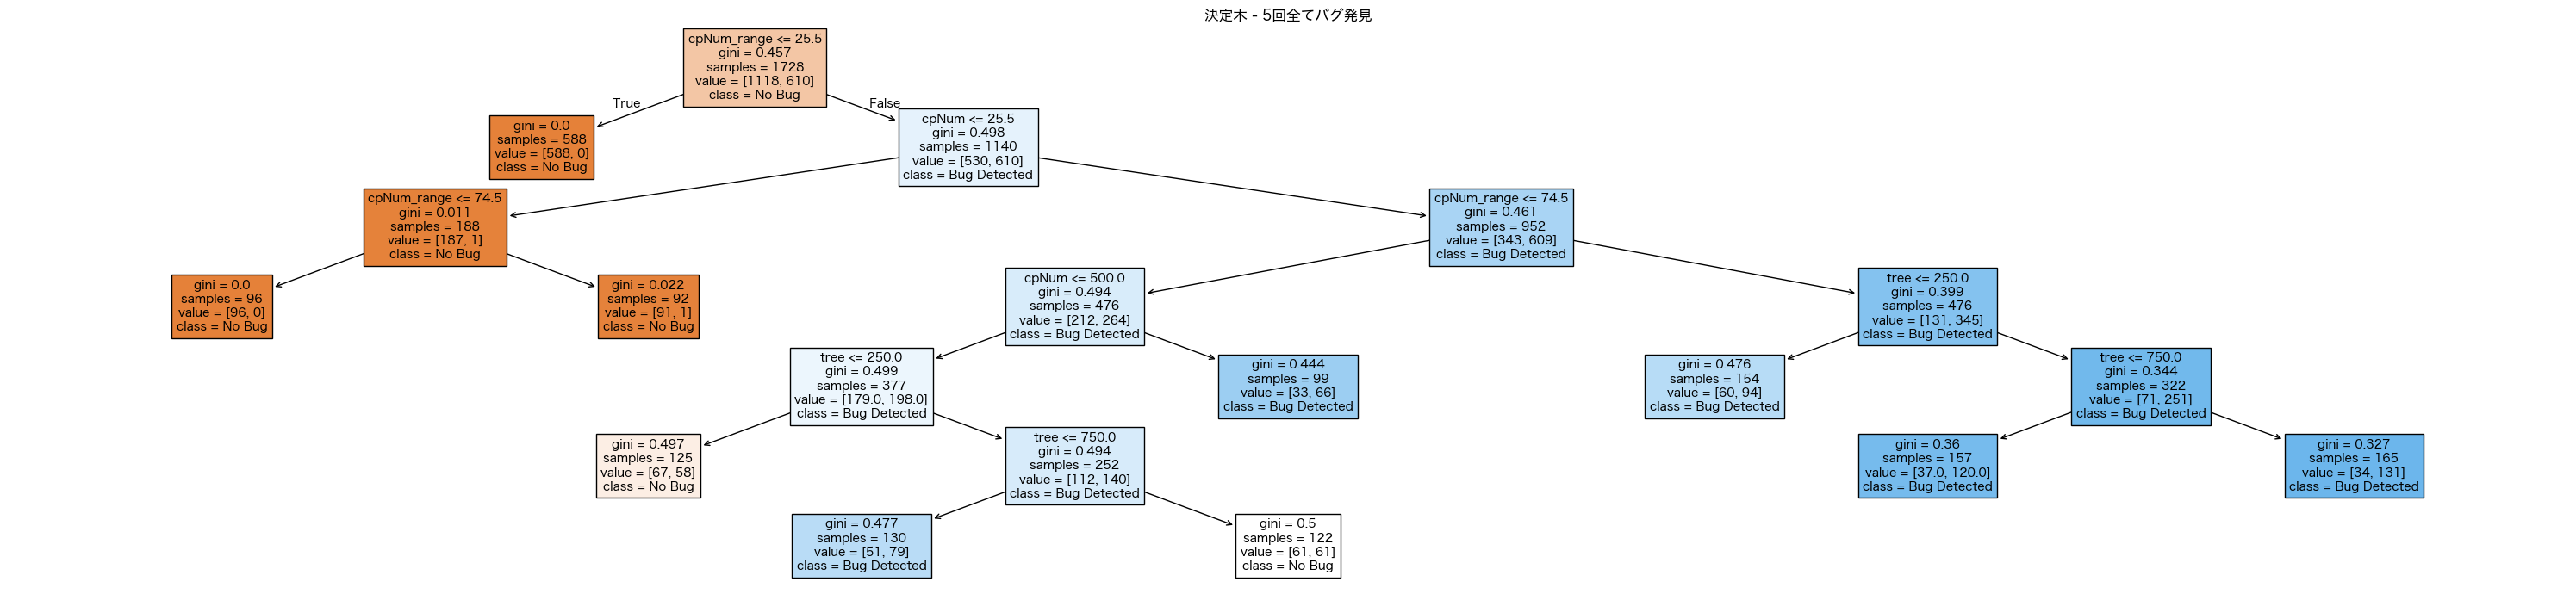

In [130]:
# 決定木の可視化（タスク0 - 深さ3まで表示）
plt.figure(figsize=(30, 7))
plot_tree(
    dt_model2,
    feature_names=X2.columns,
    class_names=['No Bug', 'Bug Detected'],
    max_depth=None,
    filled=True,
    fontsize=10
)
plt.title('決定木 - 5回全てバグ発見')
plt.tight_layout()
plt.show()


【決定木】特徴量重要度（5回全てバグ発見）
       feature  importance
2  cpNum_range    0.630165
1        cpNum    0.345902
0         tree    0.023933
3    cpNum_dir    0.000000


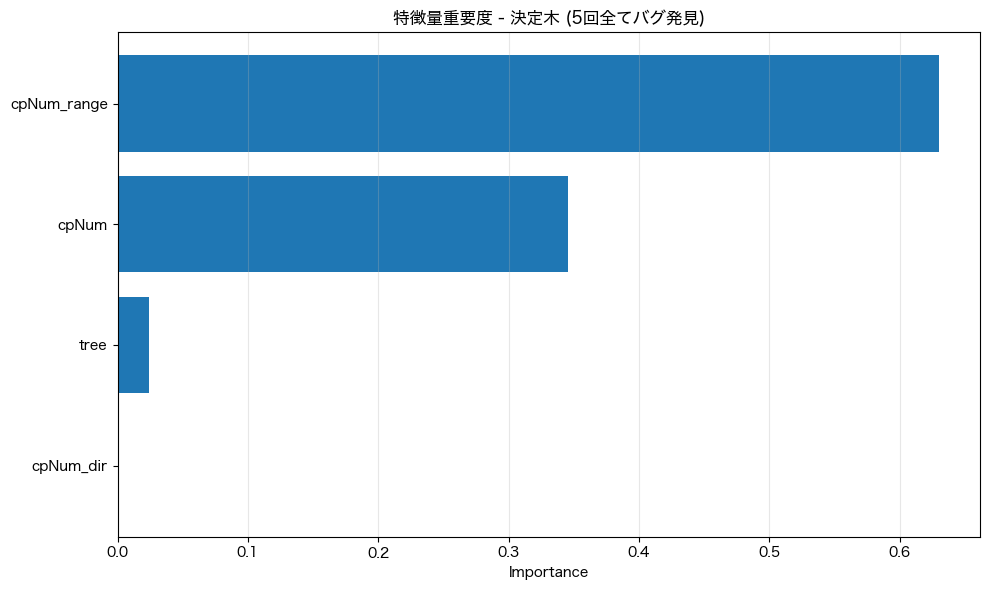

In [131]:
# 決定木の特徴量重要度（タスク2）
feature_importance_dt2 = pd.DataFrame({
    'feature': X2.columns,
    'importance': dt_model2.feature_importances_
}).sort_values('importance', ascending=False)

print("\n【決定木】特徴量重要度（5回全てバグ発見）")
print(feature_importance_dt2)

# 特徴量重要度の可視化
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_dt2['feature'], feature_importance_dt2['importance'])
plt.xlabel('Importance')
plt.title('特徴量重要度 - 決定木 (5回全てバグ発見)')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()



【ランダムフォレスト（5回全てバグ発見）】10分割交差検証結果
{'fit_time': array([0.09242511, 0.08603787, 0.09567904, 0.10349011, 0.10457706,
       0.10092974, 0.10420609, 0.09679103, 0.08236504, 0.07054114]), 'score_time': array([0.02430296, 0.02414298, 0.0223999 , 0.01872897, 0.0167439 ,
       0.01682711, 0.01580191, 0.01783514, 0.01732302, 0.01474881]), 'test_accuracy': array([0.74537037, 0.77314815, 0.78240741, 0.81481481, 0.80092593,
       0.76388889, 0.84259259, 0.81944444, 0.76851852, 0.77777778]), 'train_accuracy': array([0.79938272, 0.79835391, 0.80452675, 0.79578189, 0.79423868,
       0.79938272, 0.79063786, 0.79218107, 0.80195473, 0.79989712]), 'test_precision': array([0.60576923, 0.61290323, 0.63392857, 0.66981132, 0.67741935,
       0.6       , 0.70192308, 0.67961165, 0.63      , 0.61864407]), 'train_precision': array([0.65811966, 0.64189189, 0.65805785, 0.64887064, 0.65821389,
       0.64347826, 0.63257576, 0.65774805, 0.6606383 , 0.65488565]), 'test_recall': array([0.81818182, 0.98701299, 0.9220

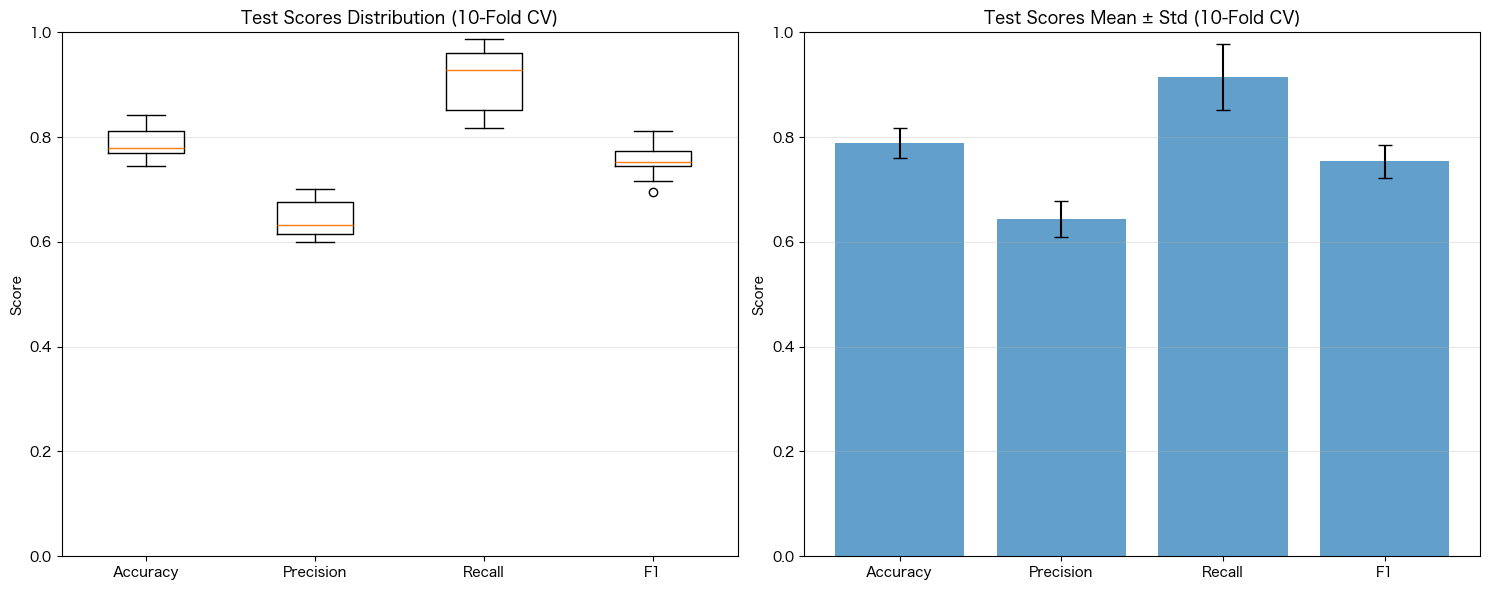

In [132]:
# タスク2: ランダムフォレストの10分割交差検証
rf_model2_cv = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    min_samples_leaf=0.05,
    n_jobs=-1
)

cv_results_rf2 = perform_cross_validation(
    rf_model2_cv,
    X2,
    y2,
    model_name="ランダムフォレスト（5回全てバグ発見）",
    n_splits=10,
    random_state=42
)



【ランダムフォレスト（5回全てバグ発見）】評価結果

【混同行列】
[[198  81]
 [ 24 129]]

【評価指標】
Accuracy:  0.7569
Precision: 0.6143
Recall:    0.8431
F1-Score:  0.7107

【ベースラインモデル】
Accuracy:  0.3542
Precision: 0.3542
Recall:    1.0000
F1-Score:  0.5231

訓練データとテストデータの正解率比較
訓練データ正解率: 0.8090
テストデータ正解率: 0.7569
AUC:       0.8516


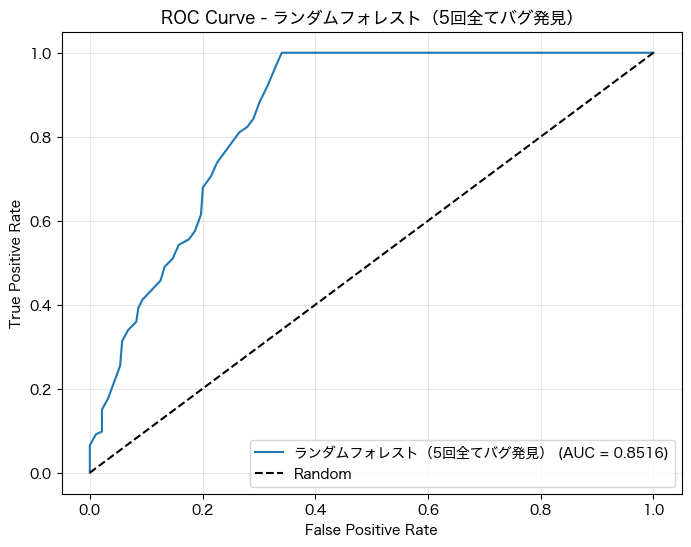

In [133]:

# ランダムフォレストモデルの訓練と評価（タスク2）
rf_model2 = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    min_samples_leaf=0.05,
    n_jobs=-1
)
rf_model2.fit(X2_train, y2_train)

# 予測
y2_pred_rf = rf_model2.predict(X2_test)
y2_pred_proba_rf = rf_model2.predict_proba(X2_test)[:, 1]

# 評価
rf_results2 = evaluate_model(y2_test, y2_pred_rf, y2_pred_proba_rf, "ランダムフォレスト（5回全てバグ発見）", X2_train, y2_train, X2_test, y2_test, rf_model2)



【ランダムフォレスト】特徴量重要度（5回全てバグ発見）
       feature  importance
2  cpNum_range    0.681338
1        cpNum    0.300539
0         tree    0.018122
3    cpNum_dir    0.000000


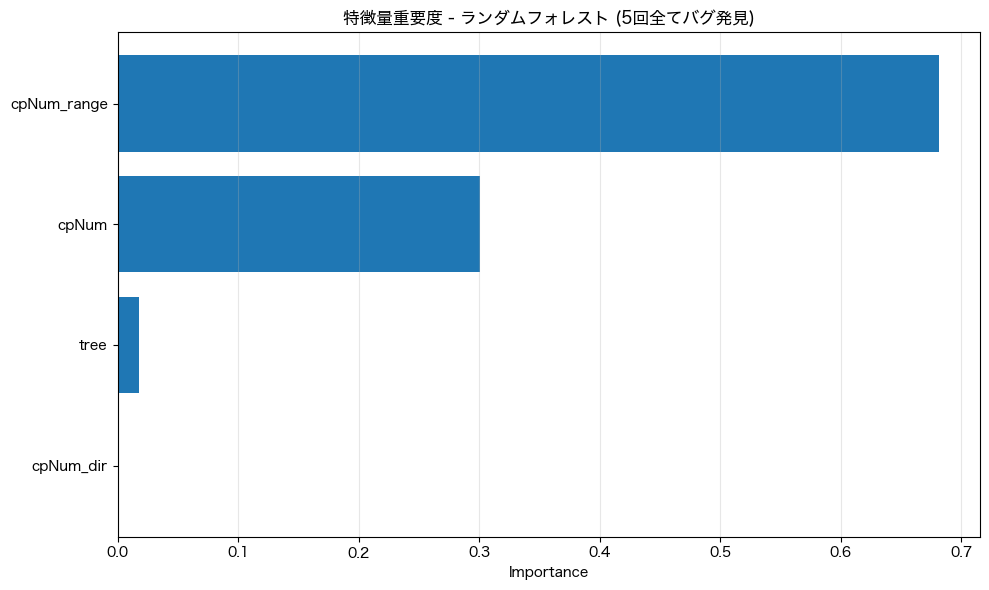

In [134]:
# ランダムフォレストの特徴量重要度（タスク2）
feature_importance_rf2 = pd.DataFrame({
    'feature': X2.columns,
    'importance': rf_model2.feature_importances_
}).sort_values('importance', ascending=False)

print("\n【ランダムフォレスト】特徴量重要度（5回全てバグ発見）")
print(feature_importance_rf2)

# 特徴量重要度の可視化
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_rf2['feature'], feature_importance_rf2['importance'])
plt.xlabel('Importance')
plt.title('特徴量重要度 - ランダムフォレスト (5回全てバグ発見)')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()



【タスク2: 5回全てバグ発見】モデル比較
                決定木  ランダムフォレスト
Accuracy   0.731481   0.756944
Precision  0.605714   0.614286
Recall     0.692810   0.843137
F1-Score   0.646341   0.710744


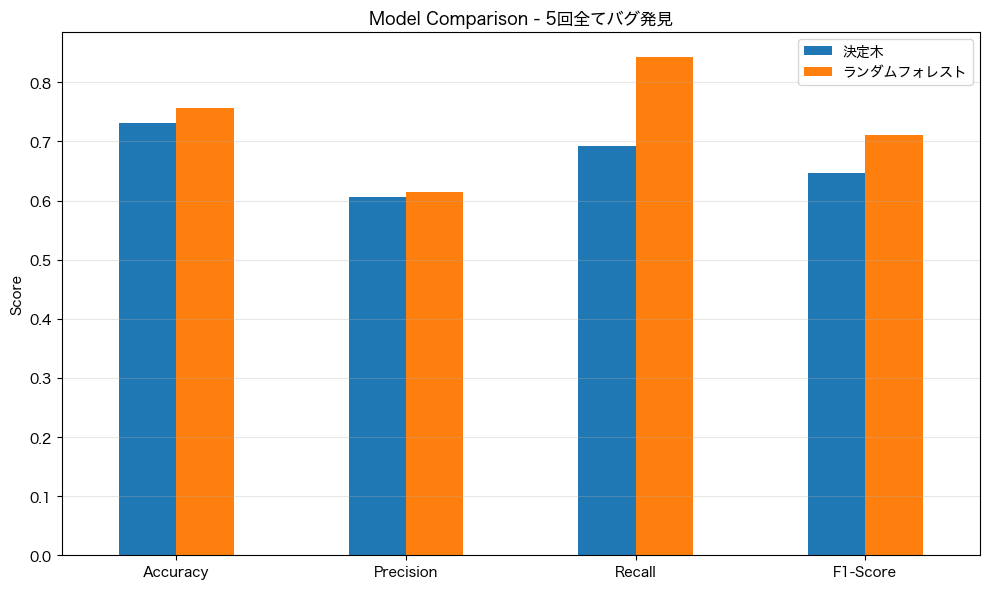

In [135]:
# タスク2の結果比較
comparison_task2 = pd.DataFrame({
    '決定木': [
        dt_results2['accuracy'],
        dt_results2['precision'],
        dt_results2['recall'],
        dt_results2['f1']
    ],
    'ランダムフォレスト': [
        rf_results2['accuracy'],
        rf_results2['precision'],
        rf_results2['recall'],
        rf_results2['f1']
    ]
}, index=['Accuracy', 'Precision', 'Recall', 'F1-Score'])

print("\n【タスク2: 5回全てバグ発見】モデル比較")
print(comparison_task2)

# 可視化
comparison_task2.plot(kind='bar', figsize=(10, 6))
plt.title('Model Comparison - 5回全てバグ発見')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()



【タスク2: 5回全てバグ発見】モデル比較
           ロジスティクス回帰       決定木  ランダムフォレスト
Accuracy      0.7000  0.731481   0.756944
Precision     0.5785  0.605714   0.614286
Recall        0.5983  0.692810   0.843137
F1-Score      0.5882  0.646341   0.710744


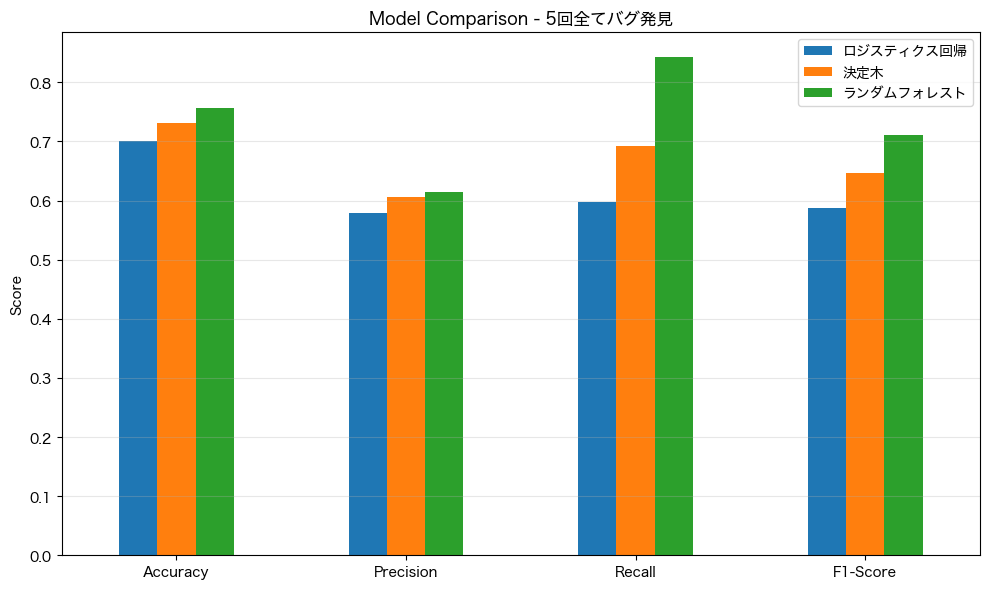

In [136]:
# ロジスティクス回帰，決定木，ランダムフォレストの比較
# タスク2の結果比較
comparison_task2 = pd.DataFrame({
    'ロジスティクス回帰': [
        0.70,
        0.5785,
        0.5983,
        0.5882
    ],
    '決定木': [
        dt_results2['accuracy'],
        dt_results2['precision'],
        dt_results2['recall'],
        dt_results2['f1']
    ],
    'ランダムフォレスト': [
        rf_results2['accuracy'],
        rf_results2['precision'],
        rf_results2['recall'],
        rf_results2['f1']
    ]
}, index=['Accuracy', 'Precision', 'Recall', 'F1-Score'])

print("\n【タスク2: 5回全てバグ発見】モデル比較")
print(comparison_task2)

# 可視化
comparison_task2.plot(kind='bar', figsize=(10, 6))
plt.title('Model Comparison - 5回全てバグ発見')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()